In [1]:
#general tools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3

#data processing tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score
from scipy import stats
import shap
from sklearn.neighbors import KNeighborsRegressor

#model building tools
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from catboost import Pool
import statsmodels.api as sm

#model productionalization tools
import pickle


In [2]:
#Establish connection with the local trulia housing .db SQLite file
conn = sqlite3.connect('C:/Users/dakot/Desktop/DataScience/projects/dakota_data_science_projects/santa_barbara_realestate_analysis/trulia_sb_house_data.db')

#read the "cleaned data" table from the trulia housing database and store in a pandas dataframe
df = pd.read_sql_query("SELECT * FROM trulia_house_SB_data_cleaned", conn)

In [3]:
#general summary information for the dataframe:
df.head()
df.columns

Index(['level_0', 'index', 'price', 'address', 'zip', 'num_bedrooms',
       'num_baths', 'building_sqft', 'year_built', 'lot_area',
       'home_description', 'feature_list', 'house_age', 'has_garage',
       'has_fireplace', 'has_ocean_views', 'has_mountain_views',
       'has_hope_ranch', 'has_montecito', 'has_pool', 'has_upstairs', 'has_IV',
       'building_sqft_was_missing'],
      dtype='object')

In [4]:
df.describe()

,level_0,index,price,num_bedrooms,num_baths,building_sqft,year_built,lot_area,house_age,has_garage,has_fireplace,has_ocean_views,has_mountain_views,has_hope_ranch,has_montecito,has_pool,has_upstairs,has_IV,building_sqft_was_missing
count,906.000000,906.000000,906.000000,906.000000,906.000000,750.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000
mean,633.844371,633.844371,2.697768,3.615894,3.197351,2.563863,1966.833333,0.837355,55.166667,0.390728,0.417219,0.112583,0.185430,0.045254,0.160044,0.239514,0.120309,0.003311,0.172185
std,374.363060,374.363060,1.902631,0.977273,1.391273,1.409905,24.700680,1.570894,24.700680,0.488183,0.493372,0.316257,0.388861,0.207975,0.366850,0.427023,0.325502,0.057480,0.377750
min,0.000000,0.000000,0.009500,2.000000,1.500000,0.668000,1900.000000,0.000002,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,307.250000,307.250000,1.360318,3.000000,2.000000,1.564000,1956.000000,0.170000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,623.000000,623.000000,1.980500,4.000000,3.000000,2.189500,1963.000000,0.260000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,957.750000,957.750000,3.490750,4.000000,4.000000,3.043750,1985.000000,1.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1296.000000,1296.000000,9.910000,9.000000,11.000000,10.823000,2021.000000,15.000000,122.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
#drop features that are not useful for the model
df_model=df.drop(['level_0','index', 'address', 'year_built', 'home_description', 'feature_list'],axis=1)

In [6]:
#The only cataorical feature is the zipcode. Use one hot encoding to create dummy variables for zip code categories
enc=OneHotEncoder(handle_unknown='ignore')

enc_df=pd.DataFrame(enc.fit_transform(df[['zip']]).toarray())
enc_df.columns=enc.get_feature_names(['zip'])

df_model=df_model.join(enc_df)
df_model.head()

,price,zip,num_bedrooms,num_baths,building_sqft,lot_area,house_age,has_garage,has_fireplace,has_ocean_views,...,building_sqft_was_missing,zip_93067,zip_93101,zip_93103,zip_93105,zip_93108,zip_93109,zip_93110,zip_93111,zip_93117
0,3.900000,93108,3.0,3.0,2.354,1.00,62.0,0,0,0,...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.780000,93105,3.0,2.0,1.395,0.14,73.0,1,1,0,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.350000,93105,3.0,2.0,1.344,0.50,50.0,0,1,0,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.899000,93109,3.0,3.0,2.558,0.50,42.0,0,1,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.824215,93109,4.0,2.0,1.407,0.14,63.0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
#Print the number of null values in each column 
print(df_model.isnull().sum())

price                          0
zip                            0
num_bedrooms                   0
num_baths                      0
building_sqft                156
lot_area                       0
house_age                      0
has_garage                     0
has_fireplace                  0
has_ocean_views                0
has_mountain_views             0
has_hope_ranch                 0
has_montecito                  0
has_pool                       0
has_upstairs                   0
has_IV                         0
building_sqft_was_missing      0
zip_93067                      0
zip_93101                      0
zip_93103                      0
zip_93105                      0
zip_93108                      0
zip_93109                      0
zip_93110                      0
zip_93111                      0
zip_93117                      0
dtype: int64


In [8]:
#Here we perform some imputation to approximate and fill in any nan values

def knn_imputer(df):
    #This function takes in a dataframe and imputes missing numeric values with a knn regressor

    #isolate the columns with categorical data
    cat_data=df.select_dtypes(exclude=[np.number])
    
    #isolate the columns with numeric data
    numeric_data=df.select_dtypes(include=[np.number])

    nan_columns=numeric_data.columns[numeric_data.isna().any()].tolist()

    no_nan_columns=numeric_data.drop(columns=nan_columns).columns

    for col in nan_columns:

        KNN_test_data=numeric_data[numeric_data[col].isna()]

        KNN_train_data=numeric_data.dropna()

        KNN_model=KNeighborsRegressor(n_neighbors=3)

        KNN_model.fit(KNN_train_data[no_nan_columns], KNN_train_data[col])

        numeric_data.loc[numeric_data[col].isna(),col]=KNN_model.predict(KNN_test_data[no_nan_columns])

    return pd.concat([numeric_data, cat_data], axis=1)

#df_model=knn_imputer(df_model)
df_model.dropna(subset=['building_sqft'], inplace=True)

In [9]:
#Print the number of null values in each column to ensure that no columns have null values
print(df_model.isnull().sum())

price                        0
zip                          0
num_bedrooms                 0
num_baths                    0
building_sqft                0
lot_area                     0
house_age                    0
has_garage                   0
has_fireplace                0
has_ocean_views              0
has_mountain_views           0
has_hope_ranch               0
has_montecito                0
has_pool                     0
has_upstairs                 0
has_IV                       0
building_sqft_was_missing    0
zip_93067                    0
zip_93101                    0
zip_93103                    0
zip_93105                    0
zip_93108                    0
zip_93109                    0
zip_93110                    0
zip_93111                    0
zip_93117                    0
dtype: int64


In [10]:
#Final descriptive statistics for each numeric column in the dataframe
df_model.describe()

,price,num_bedrooms,num_baths,building_sqft,lot_area,house_age,has_garage,has_fireplace,has_ocean_views,has_mountain_views,...,building_sqft_was_missing,zip_93067,zip_93101,zip_93103,zip_93105,zip_93108,zip_93109,zip_93110,zip_93111,zip_93117
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,...,750.0,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,2.556597,3.609333,3.133333,2.563863,0.724675,54.900000,0.417333,0.456000,0.118667,0.200000,...,0.0,0.001333,0.061333,0.105333,0.192000,0.189333,0.084000,0.113333,0.110667,0.142667
std,1.790440,0.955998,1.356715,1.409905,1.401334,23.990917,0.493448,0.498393,0.323612,0.400267,...,0.0,0.036515,0.240101,0.307187,0.394136,0.392035,0.277573,0.317211,0.313928,0.349966
min,0.437500,2.000000,2.000000,0.668000,0.000002,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.335000,3.000000,2.000000,1.564000,0.169995,38.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.860250,4.000000,3.000000,2.189500,0.230002,59.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.047500,4.000000,4.000000,3.043750,0.800000,66.000000,1.000000,1.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.815000,9.000000,11.000000,10.823000,15.000000,122.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
#normalize the skewed numeric variables
df_model['num_baths']=stats.boxcox(df_model['num_baths'])[0]

df_model['lot_area']=stats.boxcox(df_model['lot_area'])[0]

df_model["building_sqft"] = np.log1p(df_model["building_sqft"])

#df_model["house_age"] = np.log1p(df_model["house_age"])

In [12]:
#normalize the target variable

normalized_price_data=np.log1p(df_model['price'])

In [13]:
#Establish X and y. Split data into training and testing set

X=df_model.drop(['price','zip'],axis=1)

y=normalized_price_data
#y=df_model['price']

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)


In [14]:
#define function to find rmse
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [15]:
#define function to find mae
def mae(y, y_pred):
    return np.mean(np.abs(y-y_pred))

In [16]:
#define a function to perform cross validation and firn RMSE for model
def cv_rmse(model):
    return(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=3)))


In [17]:
#Start the model building process by making a few representative models with statsmodels and catboost 
#to visualize the quality of the fit and the relative importance of each feature

#Here we start by using statsmodel multilinear regression api because it makes it easy to view the quality of 
#the linear fit and the P values for each variable 

X_sm=sm.add_constant(X)
model=sm.OLS(y,X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     137.5
Date:                Mon, 17 Jan 2022   Prob (F-statistic):          1.22e-241
Time:                        15:28:34   Log-Likelihood:                 206.12
No. Observations:                 750   AIC:                            -366.2
Df Residuals:                     727   BIC:                            -260.0
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.2141      0.057      3.745      0.000       0.102       0.326
num_bedrooms                 -0.0491      0.009     -5.188      0.000      -0.068      -0.030
num_baths                     0.4281      0.111      3.857      0.000       0.210       0.646
building_sqft                 0.7054      0.047     15.128      0.000       0.614       0.797
lot_area                      0.0566      0.009      6.545      0.000       0.040       0.074
house_age                     0.0009      0.000      2.657      0.008       0.000       0.002
has_garage                    0.0030      0.015      0.206      0.837      -0.026       0.032
has_fireplace                -0.0050      0.014     -0.350      0.727      -0.033       0.023
has_ocean_views              -0.0150      0.023     -0.657      0.511      -0.060       0.030
has_mountain_views           -0.0112      0.018     -0.617      0.537      -0.047       0.024
has_hope_ranch                0.1148      0.042      2.718      0.007       0.032       0.198
has_montecito                 0.0255      0.031      0.831      0.406      -0.035       0.086
has_pool                      0.0266      0.018      1.484      0.138      -0.009       0.062
has_upstairs                 -0.0057      0.021     -0.274      0.784      -0.046       0.035
has_IV                        0.0218      0.110      0.197      0.844      -0.195       0.239
building_sqft_was_missing -2.862e-17    5.6e-17     -0.511      0.610   -1.39e-16    8.14e-17
zip_93067                     0.1637      0.170      0.963      0.336      -0.170       0.498
zip_93101                    -0.0149      0.034     -0.445      0.656      -0.081       0.051
zip_93103                     0.0698      0.029      2.415      0.016       0.013       0.127
zip_93105                    -0.0471      0.025     -1.882      0.060      -0.096       0.002
zip_93108                     0.2276      0.033      6.807      0.000       0.162       0.293
zip_93109                     0.1437      0.029      4.876      0.000       0.086       0.202
zip_93110                    -0.0640      0.031     -2.048      0.041      -0.125      -0.003
zip_93111                    -0.1293      0.028     -4.625      0.000      -0.184      -0.074
zip_93117                    -0.1354      0.027     -5.048      0.000      -0.188      -0.083
==============================================================================
Omnibus:                       71.528   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.160
Skew:                           0.362   Prob(JB):                     1.08e-60
Kurtosis:                       5.883   Cond. No.                     2.80e+18
========================================================

In [18]:
# Using a catboost model makes it easy to visualize the appropriate hyperparameter tuning and the "importance" of 
#different features in a boosted tree type model

cat=CatBoostRegressor()
cat_model=cat.fit(X_train,y_train,eval_set=(X_test,y_test),plot=True, verbose=0)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [19]:
# Get an initial score for the catboost model with default parameters

cat_pred=cat_model.predict(X_test)
cat_score=mae(np.expm1(y_test), np.expm1(cat_pred))
print(cat_score)

0.42489949759431955


In [20]:
#Print out feature importances for the catboost model for each feature 

feat_imp=cat_model.get_feature_importance(prettified=True)
feat_imp

,Feature Id,Importances
0,building_sqft,28.306175
1,lot_area,18.078183
2,zip_93108,10.580580
3,num_baths,10.229650
4,house_age,9.865087
5,zip_93109,3.323521
6,has_montecito,3.225175
7,num_bedrooms,3.076287
8,has_fireplace,2.304279
9,zip_93117,2.276367


In [21]:
#The catboost model also makes it easy to quantify the degree of interaction between features, which is useful in several ways

train_data=Pool(X_train)
interaction=cat_model.get_feature_importance(train_data, type="Interaction")
column_names=X_train.columns.values
interaction=pd.DataFrame(interaction, columns=["feature1", "feature2", "importance"])
interaction.feature1=interaction.feature1.apply(lambda l: column_names[int(l)])
interaction.feature2=interaction.feature2.apply(lambda l: column_names[int(l)])
interaction.head(20)

,feature1,feature2,importance
0,building_sqft,lot_area,10.268916
1,lot_area,house_age,7.770800
2,building_sqft,house_age,7.168529
3,num_baths,building_sqft,5.443506
4,num_baths,lot_area,3.760973
5,num_bedrooms,lot_area,3.441463
6,num_bedrooms,building_sqft,3.324019
7,num_baths,house_age,2.548210
8,num_bedrooms,house_age,2.274068
9,lot_area,zip_93108,2.182399


,alpha,error
28,0.0029,-0.145596


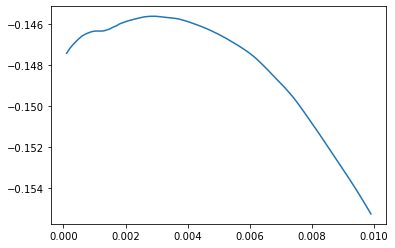

In [22]:
#For lasso regression, iterate through a range of alpha values and chose the value with the least error
alpha=[]
error=[]

for i in range(1,100):
    alpha.append(i/10000)
    lml=Lasso(alpha=(i/10000))
    error.append(np.mean(cross_val_score(lml,X_train, y_train, scoring='neg_mean_absolute_error',cv=3)))

plt.plot(alpha,error)
err=tuple(zip(alpha,error))
df_err=pd.DataFrame(err,columns=['alpha','error'])
df_err[df_err.error==max(df_err.error)]

In [30]:
#Try several different models. Due to the sparse nature of this data, we use normalized regresion techniques and tree based techniques

#Keep track of the score for each model
cv_scores_array=[]
cv_model_array=['Linear', 'Lasso', 'Random Forest', 'XGB', 'SVR', 'LGBM', 'Catboost']


#Linear regression
ln=LinearRegression()
ln.fit(X_train,y_train)
linear_score=np.average(cross_val_score(ln,X_train,y_train,scoring='neg_root_mean_squared_error',cv=3))
cv_scores_array.append(linear_score)


#For our final lasso model we chose the alpha that has the least error
lml=Lasso(alpha=.0014)
lml.fit(X_train,y_train)
lasso_score=np.average(cross_val_score(lml, X_train, y_train, scoring='neg_root_mean_squared_error',cv=3))
cv_scores_array.append(lasso_score)


#For Random forest use grid search to perform some hyperperameter tuning on rf model
rf = RandomForestRegressor()
parameters={'n_estimators':range(10,300,10), 'criterion':('mse','mae'),'max_features':('auto','sqrt','log2')}
gs_rf=GridSearchCV(rf,parameters,scoring='neg_root_mean_squared_error', cv=3)
gs_rf.fit(X_train, y_train)
optimized_rf_score=gs_rf.best_score_
cv_scores_array.append(optimized_rf_score)


#We now try an XGBoost model
xgb=XGBRegressor()
params={'n_estimators': [50, 100, 500, 1000], 'max_depth':[3,4,5], 'learning_rate': [0.01,0.5,0.8]}
gs_xgb=GridSearchCV(xgb, params, cv=3, scoring='neg_root_mean_squared_error')
gs_xgb.fit(X_train, y_train)
optimized_xgb_score=gs_xgb.best_score_
cv_scores_array.append(optimized_xgb_score)


#SVR
svr=make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))
svr_score=np.average(cross_val_score(svr,X_train, y_train, scoring='neg_root_mean_squared_error',cv=3))
cv_scores_array.append(svr_score)


#LGBM
lightgbm = LGBMRegressor()
params={'n_estimators': [50, 100, 500, 1000,7000], 'max_depth':[3,4,5], 'learning_rate': [0.01,0.5,0.8], 'num_leaves':[4, 6, 10]}
gs_lgbm=GridSearchCV(lightgbm, params, cv=3, scoring='neg_root_mean_squared_error')
gs_lgbm.fit(X_train, y_train)
lgbm_score=gs_lgbm.best_score_
cv_scores_array.append(lgbm_score)


#Catboost 
grid={'n_estimators': [50, 100, 500, 1000,7000],'max_depth':[3,4,5], 'learning_rate':[0.05, 0.005, 0.0005],  'l2_leaf_reg':[1,3,5,9]}
catboost_model=CatBoostRegressor(verbose=False)
gs_catboost=catboost_model.randomized_search(grid,cv=3, X=X_train, y=y_train, verbose=False, plot=False)
catboost_score=np.mean(cv_rmse(catboost_model))
cv_scores_array.append(catboost_score)

0:	learn: 1.2622326	test: 1.2092849	best: 1.2092849 (0)	total: 760us	remaining: 37.3ms
1:	learn: 1.2616467	test: 1.2087426	best: 1.2087426 (1)	total: 1.68ms	remaining: 40.3ms
2:	learn: 1.2610647	test: 1.2081861	best: 1.2081861 (2)	total: 2.37ms	remaining: 37.1ms
3:	learn: 1.2604796	test: 1.2076222	best: 1.2076222 (3)	total: 3.02ms	remaining: 34.7ms
4:	learn: 1.2599013	test: 1.2070795	best: 1.2070795 (4)	total: 3.7ms	remaining: 33.3ms
5:	learn: 1.2593419	test: 1.2065226	best: 1.2065226 (5)	total: 4.35ms	remaining: 31.9ms
6:	learn: 1.2587557	test: 1.2059471	best: 1.2059471 (6)	total: 5ms	remaining: 30.7ms
7:	learn: 1.2581744	test: 1.2053894	best: 1.2053894 (7)	total: 5.69ms	remaining: 29.9ms
8:	learn: 1.2576052	test: 1.2048133	best: 1.2048133 (8)	total: 6.24ms	remaining: 28.4ms
9:	learn: 1.2570417	test: 1.2042542	best: 1.2042542 (9)	total: 6.89ms	remaining: 27.6ms
10:	learn: 1.2564577	test: 1.2036881	best: 1.2036881 (10)	total: 7.54ms	remaining: 26.7ms
11:	learn: 1.2558720	test: 1.203113

203:	learn: 0.5340565	test: 0.5160352	best: 0.5160352 (203)	total: 132ms	remaining: 192ms
204:	learn: 0.5319568	test: 0.5141823	best: 0.5141823 (204)	total: 133ms	remaining: 191ms
205:	learn: 0.5300380	test: 0.5123599	best: 0.5123599 (205)	total: 133ms	remaining: 190ms
206:	learn: 0.5280468	test: 0.5104266	best: 0.5104266 (206)	total: 134ms	remaining: 190ms
207:	learn: 0.5260382	test: 0.5085442	best: 0.5085442 (207)	total: 135ms	remaining: 189ms
208:	learn: 0.5240998	test: 0.5067033	best: 0.5067033 (208)	total: 135ms	remaining: 188ms
209:	learn: 0.5220989	test: 0.5047994	best: 0.5047994 (209)	total: 136ms	remaining: 188ms
210:	learn: 0.5201379	test: 0.5029532	best: 0.5029532 (210)	total: 136ms	remaining: 187ms
211:	learn: 0.5181053	test: 0.5011166	best: 0.5011166 (211)	total: 137ms	remaining: 186ms
212:	learn: 0.5161441	test: 0.4993790	best: 0.4993790 (212)	total: 138ms	remaining: 186ms
213:	learn: 0.5142487	test: 0.4976633	best: 0.4976633 (213)	total: 138ms	remaining: 185ms
214:	learn

451:	learn: 0.2614295	test: 0.2840376	best: 0.2840376 (451)	total: 298ms	remaining: 31.7ms
452:	learn: 0.2609759	test: 0.2836380	best: 0.2836380 (452)	total: 299ms	remaining: 31ms
453:	learn: 0.2604812	test: 0.2833061	best: 0.2833061 (453)	total: 299ms	remaining: 30.3ms
454:	learn: 0.2600028	test: 0.2829749	best: 0.2829749 (454)	total: 300ms	remaining: 29.7ms
455:	learn: 0.2595532	test: 0.2826471	best: 0.2826471 (455)	total: 301ms	remaining: 29ms
456:	learn: 0.2591134	test: 0.2823463	best: 0.2823463 (456)	total: 302ms	remaining: 28.4ms
457:	learn: 0.2587012	test: 0.2820230	best: 0.2820230 (457)	total: 302ms	remaining: 27.7ms
458:	learn: 0.2582585	test: 0.2817229	best: 0.2817229 (458)	total: 303ms	remaining: 27.1ms
459:	learn: 0.2578636	test: 0.2814318	best: 0.2814318 (459)	total: 304ms	remaining: 26.4ms
460:	learn: 0.2574048	test: 0.2810956	best: 0.2810956 (460)	total: 304ms	remaining: 25.7ms
461:	learn: 0.2569359	test: 0.2807321	best: 0.2807321 (461)	total: 305ms	remaining: 25.1ms
462

197:	learn: 0.1696367	test: 0.2224599	best: 0.2223397 (175)	total: 133ms	remaining: 538ms
198:	learn: 0.1696176	test: 0.2224595	best: 0.2223397 (175)	total: 133ms	remaining: 537ms
199:	learn: 0.1692871	test: 0.2223606	best: 0.2223397 (175)	total: 134ms	remaining: 536ms
200:	learn: 0.1692665	test: 0.2223681	best: 0.2223397 (175)	total: 135ms	remaining: 536ms
201:	learn: 0.1692479	test: 0.2223676	best: 0.2223397 (175)	total: 136ms	remaining: 535ms
202:	learn: 0.1692290	test: 0.2223607	best: 0.2223397 (175)	total: 136ms	remaining: 535ms
203:	learn: 0.1692104	test: 0.2223538	best: 0.2223397 (175)	total: 137ms	remaining: 534ms
204:	learn: 0.1691919	test: 0.2223471	best: 0.2223397 (175)	total: 137ms	remaining: 533ms
205:	learn: 0.1691742	test: 0.2223475	best: 0.2223397 (175)	total: 138ms	remaining: 532ms
206:	learn: 0.1691277	test: 0.2223266	best: 0.2223266 (206)	total: 139ms	remaining: 532ms
207:	learn: 0.1691097	test: 0.2223200	best: 0.2223200 (207)	total: 139ms	remaining: 531ms
208:	learn

453:	learn: 0.1449872	test: 0.2175343	best: 0.2175306 (452)	total: 299ms	remaining: 360ms
454:	learn: 0.1449756	test: 0.2175338	best: 0.2175306 (452)	total: 300ms	remaining: 359ms
455:	learn: 0.1447172	test: 0.2173809	best: 0.2173809 (455)	total: 301ms	remaining: 359ms
456:	learn: 0.1446128	test: 0.2173935	best: 0.2173809 (455)	total: 301ms	remaining: 358ms
457:	learn: 0.1444546	test: 0.2174781	best: 0.2173809 (455)	total: 302ms	remaining: 358ms
458:	learn: 0.1443248	test: 0.2175755	best: 0.2173809 (455)	total: 303ms	remaining: 357ms
459:	learn: 0.1441877	test: 0.2176196	best: 0.2173809 (455)	total: 303ms	remaining: 356ms
460:	learn: 0.1440789	test: 0.2176388	best: 0.2173809 (455)	total: 304ms	remaining: 356ms
461:	learn: 0.1439391	test: 0.2176970	best: 0.2173809 (455)	total: 305ms	remaining: 355ms
462:	learn: 0.1437978	test: 0.2177856	best: 0.2173809 (455)	total: 305ms	remaining: 354ms
463:	learn: 0.1437905	test: 0.2178117	best: 0.2173809 (455)	total: 306ms	remaining: 354ms
464:	learn

709:	learn: 0.1249587	test: 0.2150568	best: 0.2148903 (627)	total: 467ms	remaining: 191ms
710:	learn: 0.1249545	test: 0.2150553	best: 0.2148903 (627)	total: 467ms	remaining: 190ms
711:	learn: 0.1248504	test: 0.2149597	best: 0.2148903 (627)	total: 468ms	remaining: 189ms
712:	learn: 0.1247934	test: 0.2149844	best: 0.2148903 (627)	total: 469ms	remaining: 189ms
713:	learn: 0.1247892	test: 0.2149829	best: 0.2148903 (627)	total: 469ms	remaining: 188ms
714:	learn: 0.1247133	test: 0.2150684	best: 0.2148903 (627)	total: 470ms	remaining: 187ms
715:	learn: 0.1246571	test: 0.2150070	best: 0.2148903 (627)	total: 471ms	remaining: 187ms
716:	learn: 0.1245670	test: 0.2150304	best: 0.2148903 (627)	total: 471ms	remaining: 186ms
717:	learn: 0.1245131	test: 0.2149714	best: 0.2148903 (627)	total: 472ms	remaining: 185ms
718:	learn: 0.1245089	test: 0.2149698	best: 0.2148903 (627)	total: 473ms	remaining: 185ms
719:	learn: 0.1244229	test: 0.2149949	best: 0.2148903 (627)	total: 473ms	remaining: 184ms
720:	learn

959:	learn: 0.1127213	test: 0.2163141	best: 0.2145349 (778)	total: 634ms	remaining: 26.4ms
960:	learn: 0.1126012	test: 0.2162635	best: 0.2145349 (778)	total: 634ms	remaining: 25.7ms
961:	learn: 0.1125413	test: 0.2163081	best: 0.2145349 (778)	total: 635ms	remaining: 25.1ms
962:	learn: 0.1124810	test: 0.2163518	best: 0.2145349 (778)	total: 636ms	remaining: 24.4ms
963:	learn: 0.1124347	test: 0.2163850	best: 0.2145349 (778)	total: 636ms	remaining: 23.8ms
964:	learn: 0.1123987	test: 0.2163385	best: 0.2145349 (778)	total: 637ms	remaining: 23.1ms
965:	learn: 0.1123715	test: 0.2164021	best: 0.2145349 (778)	total: 638ms	remaining: 22.4ms
966:	learn: 0.1123300	test: 0.2164163	best: 0.2145349 (778)	total: 638ms	remaining: 21.8ms
967:	learn: 0.1122903	test: 0.2164306	best: 0.2145349 (778)	total: 639ms	remaining: 21.1ms
968:	learn: 0.1122853	test: 0.2164424	best: 0.2145349 (778)	total: 639ms	remaining: 20.5ms
969:	learn: 0.1122795	test: 0.2164418	best: 0.2145349 (778)	total: 640ms	remaining: 19.8ms

208:	learn: 1.1499091	test: 1.1004139	best: 1.1004139 (208)	total: 138ms	remaining: 4.49s
209:	learn: 1.1493852	test: 1.0999075	best: 1.0999075 (209)	total: 139ms	remaining: 4.49s
210:	learn: 1.1488650	test: 1.0993949	best: 1.0993949 (210)	total: 139ms	remaining: 4.49s
211:	learn: 1.1483384	test: 1.0988927	best: 1.0988927 (211)	total: 140ms	remaining: 4.49s
212:	learn: 1.1478308	test: 1.0984106	best: 1.0984106 (212)	total: 141ms	remaining: 4.49s
213:	learn: 1.1473350	test: 1.0979152	best: 1.0979152 (213)	total: 142ms	remaining: 4.49s
214:	learn: 1.1468122	test: 1.0974250	best: 1.0974250 (214)	total: 142ms	remaining: 4.49s
215:	learn: 1.1463223	test: 1.0969383	best: 1.0969383 (215)	total: 143ms	remaining: 4.49s
216:	learn: 1.1458243	test: 1.0964546	best: 1.0964546 (216)	total: 144ms	remaining: 4.49s
217:	learn: 1.1453012	test: 1.0959547	best: 1.0959547 (217)	total: 144ms	remaining: 4.49s
218:	learn: 1.1447822	test: 1.0954579	best: 1.0954579 (218)	total: 145ms	remaining: 4.49s
219:	learn

462:	learn: 1.0276211	test: 0.9827617	best: 0.9827617 (462)	total: 305ms	remaining: 4.31s
463:	learn: 1.0271585	test: 0.9823182	best: 0.9823182 (463)	total: 306ms	remaining: 4.31s
464:	learn: 1.0267077	test: 0.9818943	best: 0.9818943 (464)	total: 307ms	remaining: 4.31s
465:	learn: 1.0262435	test: 0.9814701	best: 0.9814701 (465)	total: 308ms	remaining: 4.31s
466:	learn: 1.0257852	test: 0.9810394	best: 0.9810394 (466)	total: 308ms	remaining: 4.31s
467:	learn: 1.0253236	test: 0.9806029	best: 0.9806029 (467)	total: 309ms	remaining: 4.31s
468:	learn: 1.0248929	test: 0.9801840	best: 0.9801840 (468)	total: 310ms	remaining: 4.31s
469:	learn: 1.0244617	test: 0.9797527	best: 0.9797527 (469)	total: 310ms	remaining: 4.31s
470:	learn: 1.0240275	test: 0.9793320	best: 0.9793320 (470)	total: 311ms	remaining: 4.31s
471:	learn: 1.0235856	test: 0.9789169	best: 0.9789169 (471)	total: 312ms	remaining: 4.31s
472:	learn: 1.0231293	test: 0.9784835	best: 0.9784835 (472)	total: 312ms	remaining: 4.31s
473:	learn

718:	learn: 0.9190091	test: 0.8786468	best: 0.8786468 (718)	total: 472ms	remaining: 4.13s
719:	learn: 0.9186282	test: 0.8782714	best: 0.8782714 (719)	total: 473ms	remaining: 4.13s
720:	learn: 0.9182207	test: 0.8778885	best: 0.8778885 (720)	total: 474ms	remaining: 4.13s
721:	learn: 0.9178117	test: 0.8775072	best: 0.8775072 (721)	total: 474ms	remaining: 4.13s
722:	learn: 0.9174109	test: 0.8771303	best: 0.8771303 (722)	total: 475ms	remaining: 4.13s
723:	learn: 0.9170136	test: 0.8767436	best: 0.8767436 (723)	total: 476ms	remaining: 4.13s
724:	learn: 0.9166075	test: 0.8763496	best: 0.8763496 (724)	total: 477ms	remaining: 4.13s
725:	learn: 0.9161974	test: 0.8759619	best: 0.8759619 (725)	total: 477ms	remaining: 4.12s
726:	learn: 0.9157902	test: 0.8755643	best: 0.8755643 (726)	total: 478ms	remaining: 4.12s
727:	learn: 0.9153848	test: 0.8751692	best: 0.8751692 (727)	total: 479ms	remaining: 4.12s
728:	learn: 0.9149869	test: 0.8747897	best: 0.8747897 (728)	total: 479ms	remaining: 4.12s
729:	learn

972:	learn: 0.8236091	test: 0.7880670	best: 0.7880670 (972)	total: 640ms	remaining: 3.96s
973:	learn: 0.8232563	test: 0.7877217	best: 0.7877217 (973)	total: 640ms	remaining: 3.96s
974:	learn: 0.8228992	test: 0.7873734	best: 0.7873734 (974)	total: 641ms	remaining: 3.96s
975:	learn: 0.8225455	test: 0.7870350	best: 0.7870350 (975)	total: 642ms	remaining: 3.96s
976:	learn: 0.8221964	test: 0.7866902	best: 0.7866902 (976)	total: 643ms	remaining: 3.96s
977:	learn: 0.8218547	test: 0.7863628	best: 0.7863628 (977)	total: 643ms	remaining: 3.96s
978:	learn: 0.8215084	test: 0.7860359	best: 0.7860359 (978)	total: 644ms	remaining: 3.96s
979:	learn: 0.8211610	test: 0.7856999	best: 0.7856999 (979)	total: 645ms	remaining: 3.96s
980:	learn: 0.8208190	test: 0.7853847	best: 0.7853847 (980)	total: 645ms	remaining: 3.96s
981:	learn: 0.8204655	test: 0.7850510	best: 0.7850510 (981)	total: 646ms	remaining: 3.96s
982:	learn: 0.8201158	test: 0.7847220	best: 0.7847220 (982)	total: 647ms	remaining: 3.96s
983:	learn

1225:	learn: 0.7403325	test: 0.7093099	best: 0.7093099 (1225)	total: 807ms	remaining: 3.8s
1226:	learn: 0.7400246	test: 0.7090087	best: 0.7090087 (1226)	total: 808ms	remaining: 3.8s
1227:	learn: 0.7397110	test: 0.7087251	best: 0.7087251 (1227)	total: 809ms	remaining: 3.8s
1228:	learn: 0.7393985	test: 0.7084295	best: 0.7084295 (1228)	total: 809ms	remaining: 3.8s
1229:	learn: 0.7390868	test: 0.7081408	best: 0.7081408 (1229)	total: 810ms	remaining: 3.8s
1230:	learn: 0.7387730	test: 0.7078498	best: 0.7078498 (1230)	total: 811ms	remaining: 3.8s
1231:	learn: 0.7384857	test: 0.7075672	best: 0.7075672 (1231)	total: 812ms	remaining: 3.8s
1232:	learn: 0.7381758	test: 0.7072674	best: 0.7072674 (1232)	total: 812ms	remaining: 3.8s
1233:	learn: 0.7378697	test: 0.7069903	best: 0.7069903 (1233)	total: 813ms	remaining: 3.8s
1234:	learn: 0.7375577	test: 0.7067071	best: 0.7067071 (1234)	total: 814ms	remaining: 3.8s
1235:	learn: 0.7372414	test: 0.7064086	best: 0.7064086 (1235)	total: 814ms	remaining: 3.8s

1476:	learn: 0.6673171	test: 0.6410319	best: 0.6410319 (1476)	total: 974ms	remaining: 3.64s
1477:	learn: 0.6670640	test: 0.6407938	best: 0.6407938 (1477)	total: 975ms	remaining: 3.64s
1478:	learn: 0.6667926	test: 0.6405525	best: 0.6405525 (1478)	total: 975ms	remaining: 3.64s
1479:	learn: 0.6665264	test: 0.6403066	best: 0.6403066 (1479)	total: 976ms	remaining: 3.64s
1480:	learn: 0.6662500	test: 0.6400556	best: 0.6400556 (1480)	total: 977ms	remaining: 3.64s
1481:	learn: 0.6659791	test: 0.6397987	best: 0.6397987 (1481)	total: 977ms	remaining: 3.64s
1482:	learn: 0.6657052	test: 0.6395451	best: 0.6395451 (1482)	total: 978ms	remaining: 3.64s
1483:	learn: 0.6654318	test: 0.6392880	best: 0.6392880 (1483)	total: 979ms	remaining: 3.64s
1484:	learn: 0.6651590	test: 0.6390265	best: 0.6390265 (1484)	total: 980ms	remaining: 3.64s
1485:	learn: 0.6648812	test: 0.6387589	best: 0.6387589 (1485)	total: 980ms	remaining: 3.64s
1486:	learn: 0.6646085	test: 0.6385057	best: 0.6385057 (1486)	total: 981ms	remai

1731:	learn: 0.6024013	test: 0.5807991	best: 0.5807991 (1731)	total: 1.14s	remaining: 3.47s
1732:	learn: 0.6021639	test: 0.5805788	best: 0.5805788 (1732)	total: 1.14s	remaining: 3.47s
1733:	learn: 0.6019169	test: 0.5803502	best: 0.5803502 (1733)	total: 1.14s	remaining: 3.47s
1734:	learn: 0.6016809	test: 0.5801354	best: 0.5801354 (1734)	total: 1.14s	remaining: 3.47s
1735:	learn: 0.6014432	test: 0.5799055	best: 0.5799055 (1735)	total: 1.14s	remaining: 3.47s
1736:	learn: 0.6012099	test: 0.5796920	best: 0.5796920 (1736)	total: 1.14s	remaining: 3.47s
1737:	learn: 0.6009630	test: 0.5794727	best: 0.5794727 (1737)	total: 1.15s	remaining: 3.47s
1738:	learn: 0.6007282	test: 0.5792631	best: 0.5792631 (1738)	total: 1.15s	remaining: 3.47s
1739:	learn: 0.6004956	test: 0.5790477	best: 0.5790477 (1739)	total: 1.15s	remaining: 3.47s
1740:	learn: 0.6002483	test: 0.5788205	best: 0.5788205 (1740)	total: 1.15s	remaining: 3.46s
1741:	learn: 0.6000019	test: 0.5785879	best: 0.5785879 (1741)	total: 1.15s	remai

1986:	learn: 0.5455270	test: 0.5284985	best: 0.5284985 (1986)	total: 1.31s	remaining: 3.3s
1987:	learn: 0.5453127	test: 0.5283042	best: 0.5283042 (1987)	total: 1.31s	remaining: 3.3s
1988:	learn: 0.5451258	test: 0.5281273	best: 0.5281273 (1988)	total: 1.31s	remaining: 3.3s
1989:	learn: 0.5449111	test: 0.5279335	best: 0.5279335 (1989)	total: 1.31s	remaining: 3.3s
1990:	learn: 0.5446949	test: 0.5277301	best: 0.5277301 (1990)	total: 1.31s	remaining: 3.3s
1991:	learn: 0.5444904	test: 0.5275427	best: 0.5275427 (1991)	total: 1.31s	remaining: 3.3s
1992:	learn: 0.5442861	test: 0.5273500	best: 0.5273500 (1992)	total: 1.31s	remaining: 3.3s
1993:	learn: 0.5440851	test: 0.5271693	best: 0.5271693 (1993)	total: 1.31s	remaining: 3.3s
1994:	learn: 0.5438791	test: 0.5269781	best: 0.5269781 (1994)	total: 1.31s	remaining: 3.29s
1995:	learn: 0.5436667	test: 0.5267828	best: 0.5267828 (1995)	total: 1.31s	remaining: 3.29s
1996:	learn: 0.5434608	test: 0.5265877	best: 0.5265877 (1996)	total: 1.31s	remaining: 3.

2241:	learn: 0.4956856	test: 0.4834974	best: 0.4834974 (2241)	total: 1.48s	remaining: 3.13s
2242:	learn: 0.4955241	test: 0.4833402	best: 0.4833402 (2242)	total: 1.48s	remaining: 3.13s
2243:	learn: 0.4953409	test: 0.4831691	best: 0.4831691 (2243)	total: 1.48s	remaining: 3.13s
2244:	learn: 0.4951547	test: 0.4829946	best: 0.4829946 (2244)	total: 1.48s	remaining: 3.13s
2245:	learn: 0.4949748	test: 0.4828294	best: 0.4828294 (2245)	total: 1.48s	remaining: 3.13s
2246:	learn: 0.4947938	test: 0.4826613	best: 0.4826613 (2246)	total: 1.48s	remaining: 3.13s
2247:	learn: 0.4946125	test: 0.4825005	best: 0.4825005 (2247)	total: 1.48s	remaining: 3.13s
2248:	learn: 0.4944268	test: 0.4823359	best: 0.4823359 (2248)	total: 1.48s	remaining: 3.13s
2249:	learn: 0.4942458	test: 0.4821746	best: 0.4821746 (2249)	total: 1.48s	remaining: 3.13s
2250:	learn: 0.4940607	test: 0.4820066	best: 0.4820066 (2250)	total: 1.48s	remaining: 3.13s
2251:	learn: 0.4938729	test: 0.4818437	best: 0.4818437 (2251)	total: 1.48s	remai

2498:	learn: 0.4517885	test: 0.4444234	best: 0.4444234 (2498)	total: 1.64s	remaining: 2.96s
2499:	learn: 0.4516384	test: 0.4442897	best: 0.4442897 (2499)	total: 1.64s	remaining: 2.96s
2500:	learn: 0.4514854	test: 0.4441500	best: 0.4441500 (2500)	total: 1.64s	remaining: 2.96s
2501:	learn: 0.4513258	test: 0.4440120	best: 0.4440120 (2501)	total: 1.64s	remaining: 2.96s
2502:	learn: 0.4511612	test: 0.4438650	best: 0.4438650 (2502)	total: 1.65s	remaining: 2.96s
2503:	learn: 0.4510011	test: 0.4437243	best: 0.4437243 (2503)	total: 1.65s	remaining: 2.96s
2504:	learn: 0.4508393	test: 0.4435848	best: 0.4435848 (2504)	total: 1.65s	remaining: 2.96s
2505:	learn: 0.4506798	test: 0.4434414	best: 0.4434414 (2505)	total: 1.65s	remaining: 2.95s
2506:	learn: 0.4505189	test: 0.4433063	best: 0.4433063 (2506)	total: 1.65s	remaining: 2.95s
2507:	learn: 0.4503618	test: 0.4431678	best: 0.4431678 (2507)	total: 1.65s	remaining: 2.95s
2508:	learn: 0.4502065	test: 0.4430366	best: 0.4430366 (2508)	total: 1.65s	remai

2753:	learn: 0.4141241	test: 0.4113648	best: 0.4113648 (2753)	total: 1.81s	remaining: 2.79s
2754:	learn: 0.4139827	test: 0.4112452	best: 0.4112452 (2754)	total: 1.81s	remaining: 2.79s
2755:	learn: 0.4138426	test: 0.4111233	best: 0.4111233 (2755)	total: 1.81s	remaining: 2.79s
2756:	learn: 0.4137017	test: 0.4110020	best: 0.4110020 (2756)	total: 1.81s	remaining: 2.79s
2757:	learn: 0.4135651	test: 0.4108859	best: 0.4108859 (2757)	total: 1.81s	remaining: 2.79s
2758:	learn: 0.4134329	test: 0.4107711	best: 0.4107711 (2758)	total: 1.81s	remaining: 2.79s
2759:	learn: 0.4132971	test: 0.4106449	best: 0.4106449 (2759)	total: 1.81s	remaining: 2.79s
2760:	learn: 0.4131592	test: 0.4105246	best: 0.4105246 (2760)	total: 1.81s	remaining: 2.79s
2761:	learn: 0.4130239	test: 0.4104100	best: 0.4104100 (2761)	total: 1.81s	remaining: 2.79s
2762:	learn: 0.4128829	test: 0.4102936	best: 0.4102936 (2762)	total: 1.82s	remaining: 2.78s
2763:	learn: 0.4127442	test: 0.4101677	best: 0.4101677 (2763)	total: 1.82s	remai

3009:	learn: 0.3811651	test: 0.3830167	best: 0.3830167 (3009)	total: 1.98s	remaining: 2.62s
3010:	learn: 0.3810467	test: 0.3829122	best: 0.3829122 (3010)	total: 1.98s	remaining: 2.62s
3011:	learn: 0.3809415	test: 0.3828171	best: 0.3828171 (3011)	total: 1.98s	remaining: 2.62s
3012:	learn: 0.3808199	test: 0.3827097	best: 0.3827097 (3012)	total: 1.98s	remaining: 2.62s
3013:	learn: 0.3807148	test: 0.3826204	best: 0.3826204 (3013)	total: 1.98s	remaining: 2.62s
3014:	learn: 0.3805941	test: 0.3825185	best: 0.3825185 (3014)	total: 1.98s	remaining: 2.62s
3015:	learn: 0.3804743	test: 0.3824150	best: 0.3824150 (3015)	total: 1.98s	remaining: 2.62s
3016:	learn: 0.3803514	test: 0.3823133	best: 0.3823133 (3016)	total: 1.98s	remaining: 2.62s
3017:	learn: 0.3802252	test: 0.3822069	best: 0.3822069 (3017)	total: 1.98s	remaining: 2.62s
3018:	learn: 0.3801020	test: 0.3821010	best: 0.3821010 (3018)	total: 1.98s	remaining: 2.62s
3019:	learn: 0.3799864	test: 0.3820032	best: 0.3820032 (3019)	total: 1.98s	remai

3265:	learn: 0.3527189	test: 0.3589973	best: 0.3589973 (3265)	total: 2.14s	remaining: 2.45s
3266:	learn: 0.3526144	test: 0.3589031	best: 0.3589031 (3266)	total: 2.15s	remaining: 2.45s
3267:	learn: 0.3525148	test: 0.3588189	best: 0.3588189 (3267)	total: 2.15s	remaining: 2.45s
3268:	learn: 0.3524075	test: 0.3587372	best: 0.3587372 (3268)	total: 2.15s	remaining: 2.45s
3269:	learn: 0.3523032	test: 0.3586557	best: 0.3586557 (3269)	total: 2.15s	remaining: 2.45s
3270:	learn: 0.3521969	test: 0.3585715	best: 0.3585715 (3270)	total: 2.15s	remaining: 2.45s
3271:	learn: 0.3520962	test: 0.3584850	best: 0.3584850 (3271)	total: 2.15s	remaining: 2.45s
3272:	learn: 0.3519967	test: 0.3583987	best: 0.3583987 (3272)	total: 2.15s	remaining: 2.45s
3273:	learn: 0.3518847	test: 0.3583050	best: 0.3583050 (3273)	total: 2.15s	remaining: 2.45s
3274:	learn: 0.3517846	test: 0.3582236	best: 0.3582236 (3274)	total: 2.15s	remaining: 2.45s
3275:	learn: 0.3516778	test: 0.3581327	best: 0.3581327 (3275)	total: 2.15s	remai

3520:	learn: 0.3282794	test: 0.3387396	best: 0.3387396 (3520)	total: 2.31s	remaining: 2.28s
3521:	learn: 0.3281968	test: 0.3386711	best: 0.3386711 (3521)	total: 2.31s	remaining: 2.28s
3522:	learn: 0.3281039	test: 0.3385911	best: 0.3385911 (3522)	total: 2.31s	remaining: 2.28s
3523:	learn: 0.3280100	test: 0.3385153	best: 0.3385153 (3523)	total: 2.31s	remaining: 2.28s
3524:	learn: 0.3279170	test: 0.3384426	best: 0.3384426 (3524)	total: 2.31s	remaining: 2.28s
3525:	learn: 0.3278265	test: 0.3383689	best: 0.3383689 (3525)	total: 2.31s	remaining: 2.28s
3526:	learn: 0.3277423	test: 0.3382977	best: 0.3382977 (3526)	total: 2.31s	remaining: 2.28s
3527:	learn: 0.3276546	test: 0.3382288	best: 0.3382288 (3527)	total: 2.32s	remaining: 2.28s
3528:	learn: 0.3275639	test: 0.3381594	best: 0.3381594 (3528)	total: 2.32s	remaining: 2.28s
3529:	learn: 0.3274722	test: 0.3380801	best: 0.3380801 (3529)	total: 2.32s	remaining: 2.28s
3530:	learn: 0.3273874	test: 0.3380064	best: 0.3380064 (3530)	total: 2.32s	remai

3774:	learn: 0.3074634	test: 0.3217524	best: 0.3217524 (3774)	total: 2.48s	remaining: 2.12s
3775:	learn: 0.3073853	test: 0.3216951	best: 0.3216951 (3775)	total: 2.48s	remaining: 2.12s
3776:	learn: 0.3073105	test: 0.3216300	best: 0.3216300 (3776)	total: 2.48s	remaining: 2.12s
3777:	learn: 0.3072359	test: 0.3215675	best: 0.3215675 (3777)	total: 2.48s	remaining: 2.12s
3778:	learn: 0.3071590	test: 0.3215059	best: 0.3215059 (3778)	total: 2.48s	remaining: 2.11s
3779:	learn: 0.3070803	test: 0.3214432	best: 0.3214432 (3779)	total: 2.48s	remaining: 2.11s
3780:	learn: 0.3070027	test: 0.3213779	best: 0.3213779 (3780)	total: 2.48s	remaining: 2.11s
3781:	learn: 0.3069240	test: 0.3213115	best: 0.3213115 (3781)	total: 2.48s	remaining: 2.11s
3782:	learn: 0.3068463	test: 0.3212506	best: 0.3212506 (3782)	total: 2.48s	remaining: 2.11s
3783:	learn: 0.3067681	test: 0.3211946	best: 0.3211946 (3783)	total: 2.48s	remaining: 2.11s
3784:	learn: 0.3066958	test: 0.3211385	best: 0.3211385 (3784)	total: 2.48s	remai

4029:	learn: 0.2894584	test: 0.3074771	best: 0.3074771 (4029)	total: 2.65s	remaining: 1.95s
4030:	learn: 0.2893946	test: 0.3074256	best: 0.3074256 (4030)	total: 2.65s	remaining: 1.95s
4031:	learn: 0.2893346	test: 0.3073762	best: 0.3073762 (4031)	total: 2.65s	remaining: 1.95s
4032:	learn: 0.2892717	test: 0.3073262	best: 0.3073262 (4032)	total: 2.65s	remaining: 1.95s
4033:	learn: 0.2892031	test: 0.3072709	best: 0.3072709 (4033)	total: 2.65s	remaining: 1.95s
4034:	learn: 0.2891382	test: 0.3072224	best: 0.3072224 (4034)	total: 2.65s	remaining: 1.95s
4035:	learn: 0.2890785	test: 0.3071755	best: 0.3071755 (4035)	total: 2.65s	remaining: 1.95s
4036:	learn: 0.2890146	test: 0.3071221	best: 0.3071221 (4036)	total: 2.65s	remaining: 1.94s
4037:	learn: 0.2889477	test: 0.3070688	best: 0.3070688 (4037)	total: 2.65s	remaining: 1.94s
4038:	learn: 0.2888833	test: 0.3070163	best: 0.3070163 (4038)	total: 2.65s	remaining: 1.94s
4039:	learn: 0.2888195	test: 0.3069623	best: 0.3069623 (4039)	total: 2.65s	remai

4281:	learn: 0.2742157	test: 0.2955749	best: 0.2955749 (4281)	total: 2.81s	remaining: 1.78s
4282:	learn: 0.2741687	test: 0.2955399	best: 0.2955399 (4282)	total: 2.81s	remaining: 1.78s
4283:	learn: 0.2741117	test: 0.2954981	best: 0.2954981 (4283)	total: 2.81s	remaining: 1.78s
4284:	learn: 0.2740555	test: 0.2954560	best: 0.2954560 (4284)	total: 2.81s	remaining: 1.78s
4285:	learn: 0.2740008	test: 0.2954182	best: 0.2954182 (4285)	total: 2.81s	remaining: 1.78s
4286:	learn: 0.2739463	test: 0.2953716	best: 0.2953716 (4286)	total: 2.82s	remaining: 1.78s
4287:	learn: 0.2738878	test: 0.2953312	best: 0.2953312 (4287)	total: 2.82s	remaining: 1.78s
4288:	learn: 0.2738305	test: 0.2952833	best: 0.2952833 (4288)	total: 2.82s	remaining: 1.78s
4289:	learn: 0.2737694	test: 0.2952310	best: 0.2952310 (4289)	total: 2.82s	remaining: 1.78s
4290:	learn: 0.2737178	test: 0.2951893	best: 0.2951893 (4290)	total: 2.82s	remaining: 1.78s
4291:	learn: 0.2736651	test: 0.2951470	best: 0.2951470 (4291)	total: 2.82s	remai

4536:	learn: 0.2611005	test: 0.2855209	best: 0.2855209 (4536)	total: 2.98s	remaining: 1.62s
4537:	learn: 0.2610533	test: 0.2854810	best: 0.2854810 (4537)	total: 2.98s	remaining: 1.62s
4538:	learn: 0.2610080	test: 0.2854403	best: 0.2854403 (4538)	total: 2.98s	remaining: 1.62s
4539:	learn: 0.2609524	test: 0.2854003	best: 0.2854003 (4539)	total: 2.98s	remaining: 1.61s
4540:	learn: 0.2609079	test: 0.2853640	best: 0.2853640 (4540)	total: 2.98s	remaining: 1.61s
4541:	learn: 0.2608550	test: 0.2853238	best: 0.2853238 (4541)	total: 2.98s	remaining: 1.61s
4542:	learn: 0.2608114	test: 0.2852872	best: 0.2852872 (4542)	total: 2.98s	remaining: 1.61s
4543:	learn: 0.2607628	test: 0.2852494	best: 0.2852494 (4543)	total: 2.98s	remaining: 1.61s
4544:	learn: 0.2607149	test: 0.2852122	best: 0.2852122 (4544)	total: 2.98s	remaining: 1.61s
4545:	learn: 0.2606642	test: 0.2851744	best: 0.2851744 (4545)	total: 2.98s	remaining: 1.61s
4546:	learn: 0.2606198	test: 0.2851413	best: 0.2851413 (4546)	total: 2.98s	remai

4791:	learn: 0.2499174	test: 0.2770650	best: 0.2770650 (4791)	total: 3.15s	remaining: 1.45s
4792:	learn: 0.2498733	test: 0.2770290	best: 0.2770290 (4792)	total: 3.15s	remaining: 1.45s
4793:	learn: 0.2498370	test: 0.2770019	best: 0.2770019 (4793)	total: 3.15s	remaining: 1.45s
4794:	learn: 0.2497943	test: 0.2769670	best: 0.2769670 (4794)	total: 3.15s	remaining: 1.45s
4795:	learn: 0.2497528	test: 0.2769338	best: 0.2769338 (4795)	total: 3.15s	remaining: 1.45s
4796:	learn: 0.2497173	test: 0.2769070	best: 0.2769070 (4796)	total: 3.15s	remaining: 1.45s
4797:	learn: 0.2496751	test: 0.2768763	best: 0.2768763 (4797)	total: 3.15s	remaining: 1.45s
4798:	learn: 0.2496399	test: 0.2768514	best: 0.2768514 (4798)	total: 3.15s	remaining: 1.45s
4799:	learn: 0.2495999	test: 0.2768206	best: 0.2768206 (4799)	total: 3.15s	remaining: 1.44s
4800:	learn: 0.2495589	test: 0.2767876	best: 0.2767876 (4800)	total: 3.15s	remaining: 1.44s
4801:	learn: 0.2495181	test: 0.2767585	best: 0.2767585 (4801)	total: 3.15s	remai

5049:	learn: 0.2403310	test: 0.2698898	best: 0.2698898 (5049)	total: 3.31s	remaining: 1.28s
5050:	learn: 0.2402977	test: 0.2698668	best: 0.2698668 (5050)	total: 3.31s	remaining: 1.28s
5051:	learn: 0.2402607	test: 0.2698365	best: 0.2698365 (5051)	total: 3.31s	remaining: 1.28s
5052:	learn: 0.2402271	test: 0.2698115	best: 0.2698115 (5052)	total: 3.31s	remaining: 1.28s
5053:	learn: 0.2401935	test: 0.2697896	best: 0.2697896 (5053)	total: 3.32s	remaining: 1.28s
5054:	learn: 0.2401601	test: 0.2697647	best: 0.2697647 (5054)	total: 3.32s	remaining: 1.28s
5055:	learn: 0.2401258	test: 0.2697385	best: 0.2697385 (5055)	total: 3.32s	remaining: 1.27s
5056:	learn: 0.2400949	test: 0.2697138	best: 0.2697138 (5056)	total: 3.32s	remaining: 1.27s
5057:	learn: 0.2400580	test: 0.2696853	best: 0.2696853 (5057)	total: 3.32s	remaining: 1.27s
5058:	learn: 0.2400192	test: 0.2696555	best: 0.2696555 (5058)	total: 3.32s	remaining: 1.27s
5059:	learn: 0.2399890	test: 0.2696348	best: 0.2696348 (5059)	total: 3.32s	remai

5304:	learn: 0.2321678	test: 0.2638308	best: 0.2638308 (5304)	total: 3.48s	remaining: 1.11s
5305:	learn: 0.2321385	test: 0.2638073	best: 0.2638073 (5305)	total: 3.48s	remaining: 1.11s
5306:	learn: 0.2321062	test: 0.2637799	best: 0.2637799 (5306)	total: 3.48s	remaining: 1.11s
5307:	learn: 0.2320754	test: 0.2637579	best: 0.2637579 (5307)	total: 3.48s	remaining: 1.11s
5308:	learn: 0.2320492	test: 0.2637425	best: 0.2637425 (5308)	total: 3.48s	remaining: 1.11s
5309:	learn: 0.2320189	test: 0.2637214	best: 0.2637214 (5309)	total: 3.48s	remaining: 1.11s
5310:	learn: 0.2319905	test: 0.2636976	best: 0.2636976 (5310)	total: 3.48s	remaining: 1.11s
5311:	learn: 0.2319625	test: 0.2636764	best: 0.2636764 (5311)	total: 3.48s	remaining: 1.11s
5312:	learn: 0.2319367	test: 0.2636549	best: 0.2636549 (5312)	total: 3.48s	remaining: 1.11s
5313:	learn: 0.2319012	test: 0.2636282	best: 0.2636282 (5313)	total: 3.49s	remaining: 1.11s
5314:	learn: 0.2318695	test: 0.2636038	best: 0.2636038 (5314)	total: 3.49s	remai

5558:	learn: 0.2253007	test: 0.2588187	best: 0.2588187 (5558)	total: 3.65s	remaining: 946ms
5559:	learn: 0.2252745	test: 0.2587996	best: 0.2587996 (5559)	total: 3.65s	remaining: 945ms
5560:	learn: 0.2252479	test: 0.2587827	best: 0.2587827 (5560)	total: 3.65s	remaining: 944ms
5561:	learn: 0.2252177	test: 0.2587623	best: 0.2587623 (5561)	total: 3.65s	remaining: 944ms
5562:	learn: 0.2251889	test: 0.2587406	best: 0.2587406 (5562)	total: 3.65s	remaining: 943ms
5563:	learn: 0.2251662	test: 0.2587257	best: 0.2587257 (5563)	total: 3.65s	remaining: 942ms
5564:	learn: 0.2251375	test: 0.2587035	best: 0.2587035 (5564)	total: 3.65s	remaining: 942ms
5565:	learn: 0.2251106	test: 0.2586815	best: 0.2586815 (5565)	total: 3.65s	remaining: 941ms
5566:	learn: 0.2250872	test: 0.2586648	best: 0.2586648 (5566)	total: 3.65s	remaining: 940ms
5567:	learn: 0.2250596	test: 0.2586451	best: 0.2586451 (5567)	total: 3.65s	remaining: 940ms
5568:	learn: 0.2250350	test: 0.2586278	best: 0.2586278 (5568)	total: 3.65s	remai

5812:	learn: 0.2194129	test: 0.2546037	best: 0.2546037 (5812)	total: 3.81s	remaining: 779ms
5813:	learn: 0.2193889	test: 0.2545873	best: 0.2545873 (5813)	total: 3.81s	remaining: 778ms
5814:	learn: 0.2193660	test: 0.2545724	best: 0.2545724 (5814)	total: 3.82s	remaining: 778ms
5815:	learn: 0.2193400	test: 0.2545544	best: 0.2545544 (5815)	total: 3.82s	remaining: 777ms
5816:	learn: 0.2193201	test: 0.2545393	best: 0.2545393 (5816)	total: 3.82s	remaining: 776ms
5817:	learn: 0.2192991	test: 0.2545244	best: 0.2545244 (5817)	total: 3.82s	remaining: 776ms
5818:	learn: 0.2192760	test: 0.2545050	best: 0.2545050 (5818)	total: 3.82s	remaining: 775ms
5819:	learn: 0.2192540	test: 0.2544900	best: 0.2544900 (5819)	total: 3.82s	remaining: 774ms
5820:	learn: 0.2192359	test: 0.2544766	best: 0.2544766 (5820)	total: 3.82s	remaining: 774ms
5821:	learn: 0.2192149	test: 0.2544643	best: 0.2544643 (5821)	total: 3.82s	remaining: 773ms
5822:	learn: 0.2191951	test: 0.2544503	best: 0.2544503 (5822)	total: 3.82s	remai

6062:	learn: 0.2143929	test: 0.2509791	best: 0.2509791 (6062)	total: 3.98s	remaining: 615ms
6063:	learn: 0.2143759	test: 0.2509675	best: 0.2509675 (6063)	total: 3.98s	remaining: 615ms
6064:	learn: 0.2143586	test: 0.2509580	best: 0.2509580 (6064)	total: 3.98s	remaining: 614ms
6065:	learn: 0.2143425	test: 0.2509446	best: 0.2509446 (6065)	total: 3.98s	remaining: 613ms
6066:	learn: 0.2143269	test: 0.2509335	best: 0.2509335 (6066)	total: 3.98s	remaining: 613ms
6067:	learn: 0.2143097	test: 0.2509254	best: 0.2509254 (6067)	total: 3.98s	remaining: 612ms
6068:	learn: 0.2142961	test: 0.2509139	best: 0.2509139 (6068)	total: 3.99s	remaining: 611ms
6069:	learn: 0.2142789	test: 0.2509026	best: 0.2509026 (6069)	total: 3.99s	remaining: 611ms
6070:	learn: 0.2142559	test: 0.2508849	best: 0.2508849 (6070)	total: 3.99s	remaining: 610ms
6071:	learn: 0.2142375	test: 0.2508704	best: 0.2508704 (6071)	total: 3.99s	remaining: 610ms
6072:	learn: 0.2142172	test: 0.2508557	best: 0.2508557 (6072)	total: 3.99s	remai

6314:	learn: 0.2100233	test: 0.2478029	best: 0.2478029 (6314)	total: 4.15s	remaining: 450ms
6315:	learn: 0.2100081	test: 0.2477931	best: 0.2477931 (6315)	total: 4.15s	remaining: 449ms
6316:	learn: 0.2099945	test: 0.2477838	best: 0.2477838 (6316)	total: 4.15s	remaining: 449ms
6317:	learn: 0.2099781	test: 0.2477714	best: 0.2477714 (6317)	total: 4.15s	remaining: 448ms
6318:	learn: 0.2099626	test: 0.2477616	best: 0.2477616 (6318)	total: 4.15s	remaining: 447ms
6319:	learn: 0.2099468	test: 0.2477487	best: 0.2477487 (6319)	total: 4.15s	remaining: 447ms
6320:	learn: 0.2099311	test: 0.2477371	best: 0.2477371 (6320)	total: 4.15s	remaining: 446ms
6321:	learn: 0.2099150	test: 0.2477273	best: 0.2477273 (6321)	total: 4.15s	remaining: 445ms
6322:	learn: 0.2098990	test: 0.2477146	best: 0.2477146 (6322)	total: 4.15s	remaining: 445ms
6323:	learn: 0.2098845	test: 0.2477026	best: 0.2477026 (6323)	total: 4.15s	remaining: 444ms
6324:	learn: 0.2098680	test: 0.2476958	best: 0.2476958 (6324)	total: 4.15s	remai

6566:	learn: 0.2062566	test: 0.2451062	best: 0.2451062 (6566)	total: 4.31s	remaining: 284ms
6567:	learn: 0.2062410	test: 0.2450948	best: 0.2450948 (6567)	total: 4.32s	remaining: 284ms
6568:	learn: 0.2062293	test: 0.2450860	best: 0.2450860 (6568)	total: 4.32s	remaining: 283ms
6569:	learn: 0.2062159	test: 0.2450755	best: 0.2450755 (6569)	total: 4.32s	remaining: 283ms
6570:	learn: 0.2062041	test: 0.2450685	best: 0.2450685 (6570)	total: 4.32s	remaining: 282ms
6571:	learn: 0.2061918	test: 0.2450633	best: 0.2450633 (6571)	total: 4.32s	remaining: 281ms
6572:	learn: 0.2061775	test: 0.2450528	best: 0.2450528 (6572)	total: 4.32s	remaining: 281ms
6573:	learn: 0.2061633	test: 0.2450470	best: 0.2450470 (6573)	total: 4.32s	remaining: 280ms
6574:	learn: 0.2061467	test: 0.2450335	best: 0.2450335 (6574)	total: 4.32s	remaining: 279ms
6575:	learn: 0.2061330	test: 0.2450247	best: 0.2450247 (6575)	total: 4.32s	remaining: 279ms
6576:	learn: 0.2061214	test: 0.2450151	best: 0.2450151 (6576)	total: 4.32s	remai

6819:	learn: 0.2029799	test: 0.2427596	best: 0.2427596 (6819)	total: 4.48s	remaining: 118ms
6820:	learn: 0.2029666	test: 0.2427487	best: 0.2427487 (6820)	total: 4.48s	remaining: 118ms
6821:	learn: 0.2029543	test: 0.2427400	best: 0.2427400 (6821)	total: 4.48s	remaining: 117ms
6822:	learn: 0.2029422	test: 0.2427289	best: 0.2427289 (6822)	total: 4.48s	remaining: 116ms
6823:	learn: 0.2029280	test: 0.2427137	best: 0.2427137 (6823)	total: 4.48s	remaining: 116ms
6824:	learn: 0.2029171	test: 0.2427054	best: 0.2427054 (6824)	total: 4.49s	remaining: 115ms
6825:	learn: 0.2029041	test: 0.2426939	best: 0.2426939 (6825)	total: 4.49s	remaining: 114ms
6826:	learn: 0.2028924	test: 0.2426872	best: 0.2426872 (6826)	total: 4.49s	remaining: 114ms
6827:	learn: 0.2028805	test: 0.2426781	best: 0.2426781 (6827)	total: 4.49s	remaining: 113ms
6828:	learn: 0.2028693	test: 0.2426711	best: 0.2426711 (6828)	total: 4.49s	remaining: 112ms
6829:	learn: 0.2028576	test: 0.2426633	best: 0.2426633 (6829)	total: 4.49s	remai

45:	learn: 0.2758193	test: 0.2951843	best: 0.2951843 (45)	total: 38.7ms	remaining: 3.36ms
46:	learn: 0.2712952	test: 0.2919394	best: 0.2919394 (46)	total: 39.6ms	remaining: 2.53ms
47:	learn: 0.2664123	test: 0.2883539	best: 0.2883539 (47)	total: 40.6ms	remaining: 1.69ms
48:	learn: 0.2624235	test: 0.2856423	best: 0.2856423 (48)	total: 41.4ms	remaining: 845us
49:	learn: 0.2580881	test: 0.2824595	best: 0.2824595 (49)	total: 42.3ms	remaining: 0us

bestTest = 0.2824595013
bestIteration = 49

0:	learn: 1.2082834	test: 1.1569022	best: 1.1569022 (0)	total: 917us	remaining: 90.8ms
1:	learn: 1.1554577	test: 1.1060445	best: 1.1060445 (1)	total: 1.73ms	remaining: 84.8ms
2:	learn: 1.1047820	test: 1.0566600	best: 1.0566600 (2)	total: 2.53ms	remaining: 81.9ms
3:	learn: 1.0579460	test: 1.0121199	best: 1.0121199 (3)	total: 3.55ms	remaining: 85.3ms
4:	learn: 1.0118832	test: 0.9682661	best: 0.9682661 (4)	total: 4.35ms	remaining: 82.7ms
5:	learn: 0.9697489	test: 0.9263122	best: 0.9263122 (5)	total: 5.15ms	

97:	learn: 1.2126878	test: 1.1611640	best: 1.1611640 (97)	total: 80.5ms	remaining: 330ms
98:	learn: 1.2121887	test: 1.1606936	best: 1.1606936 (98)	total: 81.4ms	remaining: 330ms
99:	learn: 1.2116649	test: 1.1601967	best: 1.1601967 (99)	total: 83ms	remaining: 332ms
100:	learn: 1.2111719	test: 1.1597057	best: 1.1597057 (100)	total: 83.8ms	remaining: 331ms
101:	learn: 1.2107009	test: 1.1592469	best: 1.1592469 (101)	total: 84.6ms	remaining: 330ms
102:	learn: 1.2101760	test: 1.1587345	best: 1.1587345 (102)	total: 85.4ms	remaining: 329ms
103:	learn: 1.2096487	test: 1.1582323	best: 1.1582323 (103)	total: 86.3ms	remaining: 328ms
104:	learn: 1.2091573	test: 1.1577465	best: 1.1577465 (104)	total: 87.1ms	remaining: 328ms
105:	learn: 1.2086828	test: 1.1572792	best: 1.1572792 (105)	total: 88ms	remaining: 327ms
106:	learn: 1.2081964	test: 1.1568309	best: 1.1568309 (106)	total: 88.8ms	remaining: 326ms
107:	learn: 1.2077099	test: 1.1563587	best: 1.1563587 (107)	total: 89.6ms	remaining: 325ms
108:	lear

303:	learn: 1.1138117	test: 1.0655544	best: 1.0655544 (303)	total: 250ms	remaining: 161ms
304:	learn: 1.1133362	test: 1.0650954	best: 1.0650954 (304)	total: 251ms	remaining: 160ms
305:	learn: 1.1128819	test: 1.0646588	best: 1.0646588 (305)	total: 252ms	remaining: 160ms
306:	learn: 1.1124603	test: 1.0642564	best: 1.0642564 (306)	total: 253ms	remaining: 159ms
307:	learn: 1.1120306	test: 1.0638595	best: 1.0638595 (307)	total: 254ms	remaining: 158ms
308:	learn: 1.1115754	test: 1.0634142	best: 1.0634142 (308)	total: 254ms	remaining: 157ms
309:	learn: 1.1111279	test: 1.0629921	best: 1.0629921 (309)	total: 255ms	remaining: 156ms
310:	learn: 1.1106684	test: 1.0625505	best: 1.0625505 (310)	total: 256ms	remaining: 156ms
311:	learn: 1.1102015	test: 1.0620899	best: 1.0620899 (311)	total: 257ms	remaining: 155ms
312:	learn: 1.1097202	test: 1.0616273	best: 1.0616273 (312)	total: 258ms	remaining: 154ms
313:	learn: 1.1092432	test: 1.0611521	best: 1.0611521 (313)	total: 258ms	remaining: 153ms
314:	learn

8:	learn: 1.2117262	test: 1.1604228	best: 1.1604228 (8)	total: 8.04ms	remaining: 886ms
9:	learn: 1.2061525	test: 1.1552805	best: 1.1552805 (9)	total: 8.98ms	remaining: 889ms
10:	learn: 1.2005368	test: 1.1498731	best: 1.1498731 (10)	total: 10.1ms	remaining: 907ms
11:	learn: 1.1951464	test: 1.1446665	best: 1.1446665 (11)	total: 10.9ms	remaining: 894ms
12:	learn: 1.1896440	test: 1.1393790	best: 1.1393790 (12)	total: 11.7ms	remaining: 888ms
13:	learn: 1.1843735	test: 1.1341807	best: 1.1341807 (13)	total: 12.5ms	remaining: 883ms
14:	learn: 1.1789059	test: 1.1290286	best: 1.1290286 (14)	total: 13.4ms	remaining: 877ms
15:	learn: 1.1734219	test: 1.1237813	best: 1.1237813 (15)	total: 14.2ms	remaining: 872ms
16:	learn: 1.1680738	test: 1.1186848	best: 1.1186848 (16)	total: 15ms	remaining: 868ms
17:	learn: 1.1626650	test: 1.1134619	best: 1.1134619 (17)	total: 15.9ms	remaining: 865ms
18:	learn: 1.1573002	test: 1.1081742	best: 1.1081742 (18)	total: 16.7ms	remaining: 860ms
19:	learn: 1.1520974	test: 

213:	learn: 0.5009076	test: 0.4927590	best: 0.4927590 (213)	total: 177ms	remaining: 651ms
214:	learn: 0.4989380	test: 0.4910490	best: 0.4910490 (214)	total: 178ms	remaining: 651ms
215:	learn: 0.4969654	test: 0.4893201	best: 0.4893201 (215)	total: 179ms	remaining: 651ms
216:	learn: 0.4950620	test: 0.4876335	best: 0.4876335 (216)	total: 180ms	remaining: 650ms
217:	learn: 0.4931426	test: 0.4859384	best: 0.4859384 (217)	total: 181ms	remaining: 649ms
218:	learn: 0.4911774	test: 0.4842442	best: 0.4842442 (218)	total: 182ms	remaining: 648ms
219:	learn: 0.4893349	test: 0.4825872	best: 0.4825872 (219)	total: 183ms	remaining: 647ms
220:	learn: 0.4874984	test: 0.4809695	best: 0.4809695 (220)	total: 183ms	remaining: 647ms
221:	learn: 0.4856353	test: 0.4793962	best: 0.4793962 (221)	total: 184ms	remaining: 646ms
222:	learn: 0.4837202	test: 0.4777250	best: 0.4777250 (222)	total: 185ms	remaining: 645ms
223:	learn: 0.4819266	test: 0.4761207	best: 0.4761207 (223)	total: 186ms	remaining: 644ms
224:	learn

417:	learn: 0.2658373	test: 0.2938723	best: 0.2938723 (417)	total: 347ms	remaining: 483ms
418:	learn: 0.2652503	test: 0.2934021	best: 0.2934021 (418)	total: 348ms	remaining: 483ms
419:	learn: 0.2646574	test: 0.2929236	best: 0.2929236 (419)	total: 349ms	remaining: 482ms
420:	learn: 0.2641055	test: 0.2925195	best: 0.2925195 (420)	total: 350ms	remaining: 482ms
421:	learn: 0.2635776	test: 0.2921051	best: 0.2921051 (421)	total: 351ms	remaining: 481ms
422:	learn: 0.2629999	test: 0.2916679	best: 0.2916679 (422)	total: 352ms	remaining: 480ms
423:	learn: 0.2624415	test: 0.2912352	best: 0.2912352 (423)	total: 353ms	remaining: 479ms
424:	learn: 0.2618811	test: 0.2908630	best: 0.2908630 (424)	total: 354ms	remaining: 478ms
425:	learn: 0.2613256	test: 0.2904617	best: 0.2904617 (425)	total: 354ms	remaining: 477ms
426:	learn: 0.2607694	test: 0.2900765	best: 0.2900765 (426)	total: 355ms	remaining: 477ms
427:	learn: 0.2602396	test: 0.2896263	best: 0.2896263 (427)	total: 356ms	remaining: 476ms
428:	learn

622:	learn: 0.1982331	test: 0.2439086	best: 0.2439086 (622)	total: 517ms	remaining: 313ms
623:	learn: 0.1980435	test: 0.2437467	best: 0.2437467 (623)	total: 518ms	remaining: 312ms
624:	learn: 0.1979031	test: 0.2436627	best: 0.2436627 (624)	total: 519ms	remaining: 311ms
625:	learn: 0.1977356	test: 0.2435502	best: 0.2435502 (625)	total: 519ms	remaining: 310ms
626:	learn: 0.1975519	test: 0.2434145	best: 0.2434145 (626)	total: 521ms	remaining: 310ms
627:	learn: 0.1973781	test: 0.2433160	best: 0.2433160 (627)	total: 521ms	remaining: 309ms
628:	learn: 0.1972083	test: 0.2431725	best: 0.2431725 (628)	total: 522ms	remaining: 308ms
629:	learn: 0.1970729	test: 0.2431149	best: 0.2431149 (629)	total: 523ms	remaining: 307ms
630:	learn: 0.1968943	test: 0.2429905	best: 0.2429905 (630)	total: 524ms	remaining: 306ms
631:	learn: 0.1967447	test: 0.2429164	best: 0.2429164 (631)	total: 525ms	remaining: 306ms
632:	learn: 0.1965636	test: 0.2427557	best: 0.2427557 (632)	total: 525ms	remaining: 305ms
633:	learn

828:	learn: 0.1768103	test: 0.2292955	best: 0.2292955 (828)	total: 687ms	remaining: 142ms
829:	learn: 0.1767397	test: 0.2292331	best: 0.2292331 (829)	total: 688ms	remaining: 141ms
830:	learn: 0.1766678	test: 0.2292405	best: 0.2292331 (829)	total: 689ms	remaining: 140ms
831:	learn: 0.1766151	test: 0.2291905	best: 0.2291905 (831)	total: 690ms	remaining: 139ms
832:	learn: 0.1765131	test: 0.2291316	best: 0.2291316 (832)	total: 691ms	remaining: 139ms
833:	learn: 0.1764161	test: 0.2291185	best: 0.2291185 (833)	total: 692ms	remaining: 138ms
834:	learn: 0.1763739	test: 0.2290994	best: 0.2290994 (834)	total: 693ms	remaining: 137ms
835:	learn: 0.1763048	test: 0.2290268	best: 0.2290268 (835)	total: 694ms	remaining: 136ms
836:	learn: 0.1762600	test: 0.2290049	best: 0.2290049 (836)	total: 694ms	remaining: 135ms
837:	learn: 0.1761980	test: 0.2289478	best: 0.2289478 (837)	total: 695ms	remaining: 134ms
838:	learn: 0.1761173	test: 0.2288761	best: 0.2288761 (838)	total: 696ms	remaining: 134ms
839:	learn

23:	learn: 1.1359895	test: 1.0879343	best: 1.0879343 (23)	total: 25.1ms	remaining: 79.5ms
24:	learn: 1.1308955	test: 1.0831736	best: 1.0831736 (24)	total: 26.3ms	remaining: 78.8ms
25:	learn: 1.1258273	test: 1.0783374	best: 1.0783374 (25)	total: 27.5ms	remaining: 78.2ms
26:	learn: 1.1209691	test: 1.0737329	best: 1.0737329 (26)	total: 28.6ms	remaining: 77.4ms
27:	learn: 1.1161981	test: 1.0692394	best: 1.0692394 (27)	total: 29.7ms	remaining: 76.4ms
28:	learn: 1.1114384	test: 1.0646369	best: 1.0646369 (28)	total: 30.8ms	remaining: 75.5ms
29:	learn: 1.1064316	test: 1.0598367	best: 1.0598367 (29)	total: 32ms	remaining: 74.7ms
30:	learn: 1.1015354	test: 1.0551464	best: 1.0551464 (30)	total: 33.1ms	remaining: 73.7ms
31:	learn: 1.0965341	test: 1.0502784	best: 1.0502784 (31)	total: 33.9ms	remaining: 72ms
32:	learn: 1.0917103	test: 1.0456973	best: 1.0456973 (32)	total: 35ms	remaining: 71ms
33:	learn: 1.0870366	test: 1.0413427	best: 1.0413427 (33)	total: 36ms	remaining: 70ms
34:	learn: 1.0825339	t

87:	learn: 0.8728366	test: 0.8369439	best: 0.8369439 (87)	total: 90.3ms	remaining: 12.3ms
88:	learn: 0.8693022	test: 0.8335552	best: 0.8335552 (88)	total: 91.2ms	remaining: 11.3ms
89:	learn: 0.8657228	test: 0.8302641	best: 0.8302641 (89)	total: 92.4ms	remaining: 10.3ms
90:	learn: 0.8620457	test: 0.8268118	best: 0.8268118 (90)	total: 93.1ms	remaining: 9.21ms
91:	learn: 0.8586653	test: 0.8237767	best: 0.8237767 (91)	total: 94.2ms	remaining: 8.19ms
92:	learn: 0.8550514	test: 0.8203740	best: 0.8203740 (92)	total: 95.3ms	remaining: 7.17ms
93:	learn: 0.8515094	test: 0.8171036	best: 0.8171036 (93)	total: 96.4ms	remaining: 6.15ms
94:	learn: 0.8481157	test: 0.8138685	best: 0.8138685 (94)	total: 97.5ms	remaining: 5.13ms
95:	learn: 0.8444388	test: 0.8104359	best: 0.8104359 (95)	total: 98.5ms	remaining: 4.11ms
96:	learn: 0.8408381	test: 0.8071137	best: 0.8071137 (96)	total: 99.8ms	remaining: 3.08ms
97:	learn: 0.8373144	test: 0.8039182	best: 0.8039182 (97)	total: 101ms	remaining: 2.06ms
98:	learn: 

272:	learn: 0.1673764	test: 0.1874325	best: 0.1874170 (268)	total: 164ms	remaining: 438ms
273:	learn: 0.1671840	test: 0.1873062	best: 0.1873062 (273)	total: 165ms	remaining: 438ms
274:	learn: 0.1671536	test: 0.1873168	best: 0.1873062 (273)	total: 166ms	remaining: 437ms
275:	learn: 0.1669819	test: 0.1871666	best: 0.1871666 (275)	total: 166ms	remaining: 437ms
276:	learn: 0.1669646	test: 0.1871696	best: 0.1871666 (275)	total: 167ms	remaining: 436ms
277:	learn: 0.1669429	test: 0.1871431	best: 0.1871431 (277)	total: 168ms	remaining: 436ms
278:	learn: 0.1668913	test: 0.1871460	best: 0.1871431 (277)	total: 168ms	remaining: 435ms
279:	learn: 0.1668673	test: 0.1871442	best: 0.1871431 (277)	total: 169ms	remaining: 435ms
280:	learn: 0.1668437	test: 0.1871428	best: 0.1871428 (280)	total: 170ms	remaining: 434ms
281:	learn: 0.1668256	test: 0.1871461	best: 0.1871428 (280)	total: 170ms	remaining: 434ms
282:	learn: 0.1665907	test: 0.1873477	best: 0.1871428 (280)	total: 171ms	remaining: 433ms
283:	learn

533:	learn: 0.1428209	test: 0.1860073	best: 0.1859664 (399)	total: 331ms	remaining: 288ms
534:	learn: 0.1426546	test: 0.1858671	best: 0.1858671 (534)	total: 331ms	remaining: 288ms
535:	learn: 0.1425347	test: 0.1858641	best: 0.1858641 (535)	total: 332ms	remaining: 287ms
536:	learn: 0.1425053	test: 0.1858689	best: 0.1858641 (535)	total: 333ms	remaining: 287ms
537:	learn: 0.1424910	test: 0.1858675	best: 0.1858641 (535)	total: 333ms	remaining: 286ms
538:	learn: 0.1424003	test: 0.1858856	best: 0.1858641 (535)	total: 334ms	remaining: 285ms
539:	learn: 0.1423081	test: 0.1858308	best: 0.1858308 (539)	total: 334ms	remaining: 285ms
540:	learn: 0.1422892	test: 0.1858436	best: 0.1858308 (539)	total: 335ms	remaining: 284ms
541:	learn: 0.1422832	test: 0.1858466	best: 0.1858308 (539)	total: 336ms	remaining: 284ms
542:	learn: 0.1421647	test: 0.1858914	best: 0.1858308 (539)	total: 336ms	remaining: 283ms
543:	learn: 0.1421162	test: 0.1858438	best: 0.1858308 (539)	total: 337ms	remaining: 282ms
544:	learn

795:	learn: 0.1262882	test: 0.1872120	best: 0.1856202 (546)	total: 497ms	remaining: 127ms
796:	learn: 0.1262355	test: 0.1872440	best: 0.1856202 (546)	total: 498ms	remaining: 127ms
797:	learn: 0.1261646	test: 0.1872416	best: 0.1856202 (546)	total: 499ms	remaining: 126ms
798:	learn: 0.1261592	test: 0.1872501	best: 0.1856202 (546)	total: 499ms	remaining: 126ms
799:	learn: 0.1261539	test: 0.1872585	best: 0.1856202 (546)	total: 500ms	remaining: 125ms
800:	learn: 0.1261040	test: 0.1872745	best: 0.1856202 (546)	total: 501ms	remaining: 124ms
801:	learn: 0.1259511	test: 0.1873044	best: 0.1856202 (546)	total: 501ms	remaining: 124ms
802:	learn: 0.1258605	test: 0.1873265	best: 0.1856202 (546)	total: 502ms	remaining: 123ms
803:	learn: 0.1257891	test: 0.1873784	best: 0.1856202 (546)	total: 502ms	remaining: 122ms
804:	learn: 0.1257250	test: 0.1874187	best: 0.1856202 (546)	total: 503ms	remaining: 122ms
805:	learn: 0.1257198	test: 0.1874269	best: 0.1856202 (546)	total: 504ms	remaining: 121ms
806:	learn

24:	learn: 0.4745819	test: 0.5195687	best: 0.5195687 (24)	total: 15.6ms	remaining: 607ms
25:	learn: 0.4591567	test: 0.5039406	best: 0.5039406 (25)	total: 16.3ms	remaining: 609ms
26:	learn: 0.4444103	test: 0.4887023	best: 0.4887023 (26)	total: 16.9ms	remaining: 607ms
27:	learn: 0.4314119	test: 0.4753816	best: 0.4753816 (27)	total: 17.5ms	remaining: 607ms
28:	learn: 0.4192492	test: 0.4625194	best: 0.4625194 (28)	total: 18.2ms	remaining: 610ms
29:	learn: 0.4076460	test: 0.4507464	best: 0.4507464 (29)	total: 18.9ms	remaining: 610ms
30:	learn: 0.3959487	test: 0.4386324	best: 0.4386324 (30)	total: 20.3ms	remaining: 633ms
31:	learn: 0.3845304	test: 0.4274550	best: 0.4274550 (31)	total: 20.9ms	remaining: 632ms
32:	learn: 0.3740203	test: 0.4165112	best: 0.4165112 (32)	total: 21.7ms	remaining: 635ms
33:	learn: 0.3640012	test: 0.4058494	best: 0.4058494 (33)	total: 22.2ms	remaining: 632ms
34:	learn: 0.3550115	test: 0.3961295	best: 0.3961295 (34)	total: 22.8ms	remaining: 630ms
35:	learn: 0.3467195	

280:	learn: 0.1539316	test: 0.2029692	best: 0.2029519 (277)	total: 183ms	remaining: 469ms
281:	learn: 0.1537872	test: 0.2029424	best: 0.2029424 (281)	total: 184ms	remaining: 469ms
282:	learn: 0.1534475	test: 0.2029704	best: 0.2029424 (281)	total: 185ms	remaining: 468ms
283:	learn: 0.1532646	test: 0.2028297	best: 0.2028297 (283)	total: 185ms	remaining: 467ms
284:	learn: 0.1532286	test: 0.2028297	best: 0.2028297 (283)	total: 186ms	remaining: 467ms
285:	learn: 0.1531910	test: 0.2028454	best: 0.2028297 (283)	total: 187ms	remaining: 466ms
286:	learn: 0.1531544	test: 0.2028613	best: 0.2028297 (283)	total: 187ms	remaining: 465ms
287:	learn: 0.1530341	test: 0.2028455	best: 0.2028297 (283)	total: 188ms	remaining: 464ms
288:	learn: 0.1529992	test: 0.2028458	best: 0.2028297 (283)	total: 188ms	remaining: 464ms
289:	learn: 0.1529004	test: 0.2028718	best: 0.2028297 (283)	total: 189ms	remaining: 463ms
290:	learn: 0.1527203	test: 0.2029124	best: 0.2028297 (283)	total: 190ms	remaining: 462ms
291:	learn

539:	learn: 0.1304372	test: 0.2014718	best: 0.2012632 (373)	total: 350ms	remaining: 298ms
540:	learn: 0.1304206	test: 0.2014786	best: 0.2012632 (373)	total: 351ms	remaining: 298ms
541:	learn: 0.1304063	test: 0.2014741	best: 0.2012632 (373)	total: 351ms	remaining: 297ms
542:	learn: 0.1302425	test: 0.2015174	best: 0.2012632 (373)	total: 352ms	remaining: 296ms
543:	learn: 0.1300077	test: 0.2015853	best: 0.2012632 (373)	total: 353ms	remaining: 296ms
544:	learn: 0.1299911	test: 0.2015984	best: 0.2012632 (373)	total: 353ms	remaining: 295ms
545:	learn: 0.1299772	test: 0.2015945	best: 0.2012632 (373)	total: 354ms	remaining: 294ms
546:	learn: 0.1299636	test: 0.2015907	best: 0.2012632 (373)	total: 355ms	remaining: 294ms
547:	learn: 0.1299284	test: 0.2015816	best: 0.2012632 (373)	total: 355ms	remaining: 293ms
548:	learn: 0.1298120	test: 0.2015603	best: 0.2012632 (373)	total: 356ms	remaining: 292ms
549:	learn: 0.1297529	test: 0.2015289	best: 0.2012632 (373)	total: 356ms	remaining: 292ms
550:	learn

789:	learn: 0.1146997	test: 0.2022595	best: 0.2009008 (695)	total: 528ms	remaining: 140ms
790:	learn: 0.1146941	test: 0.2022598	best: 0.2009008 (695)	total: 529ms	remaining: 140ms
791:	learn: 0.1145907	test: 0.2022681	best: 0.2009008 (695)	total: 529ms	remaining: 139ms
792:	learn: 0.1145809	test: 0.2022577	best: 0.2009008 (695)	total: 530ms	remaining: 138ms
793:	learn: 0.1145729	test: 0.2022570	best: 0.2009008 (695)	total: 531ms	remaining: 138ms
794:	learn: 0.1145616	test: 0.2022533	best: 0.2009008 (695)	total: 532ms	remaining: 137ms
795:	learn: 0.1145511	test: 0.2022573	best: 0.2009008 (695)	total: 532ms	remaining: 136ms
796:	learn: 0.1144694	test: 0.2023293	best: 0.2009008 (695)	total: 533ms	remaining: 136ms
797:	learn: 0.1143964	test: 0.2023210	best: 0.2009008 (695)	total: 533ms	remaining: 135ms
798:	learn: 0.1143395	test: 0.2022626	best: 0.2009008 (695)	total: 534ms	remaining: 134ms
799:	learn: 0.1143341	test: 0.2022634	best: 0.2009008 (695)	total: 535ms	remaining: 134ms
800:	learn

1:	learn: 1.1722356	test: 1.1068161	best: 1.1068161 (1)	total: 1.82ms	remaining: 910ms
2:	learn: 1.1246055	test: 1.0601688	best: 1.0601688 (2)	total: 2.42ms	remaining: 806ms
3:	learn: 1.0768856	test: 1.0144622	best: 1.0144622 (3)	total: 3.06ms	remaining: 762ms
4:	learn: 1.0324649	test: 0.9702347	best: 0.9702347 (4)	total: 3.57ms	remaining: 710ms
5:	learn: 0.9894748	test: 0.9292679	best: 0.9292679 (5)	total: 4.22ms	remaining: 700ms
6:	learn: 0.9493949	test: 0.8898686	best: 0.8898686 (6)	total: 4.8ms	remaining: 682ms
7:	learn: 0.9111801	test: 0.8525256	best: 0.8525256 (7)	total: 5.42ms	remaining: 672ms
8:	learn: 0.8741573	test: 0.8171444	best: 0.8171444 (8)	total: 6.02ms	remaining: 663ms
9:	learn: 0.8395713	test: 0.7827038	best: 0.7827038 (9)	total: 6.6ms	remaining: 654ms
10:	learn: 0.8061858	test: 0.7503777	best: 0.7503777 (10)	total: 7.18ms	remaining: 645ms
11:	learn: 0.7760486	test: 0.7220359	best: 0.7220359 (11)	total: 7.75ms	remaining: 639ms
12:	learn: 0.7444359	test: 0.6922131	best

247:	learn: 0.1720211	test: 0.2054655	best: 0.2054655 (247)	total: 161ms	remaining: 489ms
248:	learn: 0.1719998	test: 0.2054644	best: 0.2054644 (248)	total: 162ms	remaining: 489ms
249:	learn: 0.1719828	test: 0.2054682	best: 0.2054644 (248)	total: 163ms	remaining: 488ms
250:	learn: 0.1718553	test: 0.2053122	best: 0.2053122 (250)	total: 163ms	remaining: 487ms
251:	learn: 0.1718335	test: 0.2053115	best: 0.2053115 (251)	total: 164ms	remaining: 487ms
252:	learn: 0.1716833	test: 0.2053035	best: 0.2053035 (252)	total: 165ms	remaining: 486ms
253:	learn: 0.1716668	test: 0.2053069	best: 0.2053035 (252)	total: 165ms	remaining: 485ms
254:	learn: 0.1713016	test: 0.2048761	best: 0.2048761 (254)	total: 166ms	remaining: 485ms
255:	learn: 0.1712852	test: 0.2048795	best: 0.2048761 (254)	total: 167ms	remaining: 484ms
256:	learn: 0.1712698	test: 0.2048766	best: 0.2048761 (254)	total: 167ms	remaining: 484ms
257:	learn: 0.1712485	test: 0.2048757	best: 0.2048757 (257)	total: 168ms	remaining: 483ms
258:	learn

500:	learn: 0.1453533	test: 0.1975650	best: 0.1975320 (491)	total: 328ms	remaining: 326ms
501:	learn: 0.1451390	test: 0.1974472	best: 0.1974472 (501)	total: 328ms	remaining: 326ms
502:	learn: 0.1451298	test: 0.1974687	best: 0.1974472 (501)	total: 329ms	remaining: 325ms
503:	learn: 0.1449897	test: 0.1974844	best: 0.1974472 (501)	total: 330ms	remaining: 325ms
504:	learn: 0.1447952	test: 0.1973578	best: 0.1973578 (504)	total: 330ms	remaining: 324ms
505:	learn: 0.1447887	test: 0.1973707	best: 0.1973578 (504)	total: 331ms	remaining: 323ms
506:	learn: 0.1446923	test: 0.1973787	best: 0.1973578 (504)	total: 332ms	remaining: 323ms
507:	learn: 0.1446204	test: 0.1973923	best: 0.1973578 (504)	total: 332ms	remaining: 322ms
508:	learn: 0.1446143	test: 0.1974058	best: 0.1973578 (504)	total: 333ms	remaining: 321ms
509:	learn: 0.1445846	test: 0.1974453	best: 0.1973578 (504)	total: 334ms	remaining: 321ms
510:	learn: 0.1445712	test: 0.1974408	best: 0.1973578 (504)	total: 334ms	remaining: 320ms
511:	learn

755:	learn: 0.1259832	test: 0.1945170	best: 0.1944554 (750)	total: 494ms	remaining: 159ms
756:	learn: 0.1258854	test: 0.1945743	best: 0.1944554 (750)	total: 495ms	remaining: 159ms
757:	learn: 0.1258046	test: 0.1945811	best: 0.1944554 (750)	total: 496ms	remaining: 158ms
758:	learn: 0.1257841	test: 0.1946054	best: 0.1944554 (750)	total: 496ms	remaining: 158ms
759:	learn: 0.1257705	test: 0.1946109	best: 0.1944554 (750)	total: 497ms	remaining: 157ms
760:	learn: 0.1257645	test: 0.1946144	best: 0.1944554 (750)	total: 498ms	remaining: 156ms
761:	learn: 0.1256981	test: 0.1946088	best: 0.1944554 (750)	total: 499ms	remaining: 156ms
762:	learn: 0.1255062	test: 0.1944776	best: 0.1944554 (750)	total: 499ms	remaining: 155ms
763:	learn: 0.1254932	test: 0.1944827	best: 0.1944554 (750)	total: 500ms	remaining: 154ms
764:	learn: 0.1254674	test: 0.1944483	best: 0.1944483 (764)	total: 501ms	remaining: 154ms
765:	learn: 0.1253605	test: 0.1943609	best: 0.1943609 (765)	total: 501ms	remaining: 153ms
766:	learn

0:	learn: 0.4077367	total: 592us	remaining: 592ms
1:	learn: 0.3993300	total: 1.35ms	remaining: 677ms
2:	learn: 0.3904728	total: 1.93ms	remaining: 642ms
3:	learn: 0.3806825	total: 2.53ms	remaining: 630ms
4:	learn: 0.3723330	total: 3.11ms	remaining: 619ms
5:	learn: 0.3647882	total: 3.75ms	remaining: 622ms
6:	learn: 0.3567131	total: 4.37ms	remaining: 620ms
7:	learn: 0.3484903	total: 5ms	remaining: 620ms
8:	learn: 0.3426489	total: 5.6ms	remaining: 616ms
9:	learn: 0.3370190	total: 6.16ms	remaining: 610ms
10:	learn: 0.3300605	total: 6.77ms	remaining: 609ms
11:	learn: 0.3247870	total: 7.37ms	remaining: 607ms
12:	learn: 0.3188604	total: 7.99ms	remaining: 607ms
13:	learn: 0.3127896	total: 8.58ms	remaining: 604ms
14:	learn: 0.3079304	total: 9.19ms	remaining: 603ms
15:	learn: 0.3022149	total: 9.86ms	remaining: 606ms
16:	learn: 0.2967985	total: 10.5ms	remaining: 608ms
17:	learn: 0.2924839	total: 11.1ms	remaining: 607ms
18:	learn: 0.2878614	total: 11.7ms	remaining: 607ms
19:	learn: 0.2831205	total:

237:	learn: 0.1673364	total: 153ms	remaining: 490ms
238:	learn: 0.1673162	total: 154ms	remaining: 490ms
239:	learn: 0.1672748	total: 155ms	remaining: 489ms
240:	learn: 0.1672347	total: 155ms	remaining: 489ms
241:	learn: 0.1672150	total: 156ms	remaining: 489ms
242:	learn: 0.1671615	total: 157ms	remaining: 488ms
243:	learn: 0.1671085	total: 157ms	remaining: 488ms
244:	learn: 0.1670891	total: 158ms	remaining: 487ms
245:	learn: 0.1670700	total: 159ms	remaining: 487ms
246:	learn: 0.1670316	total: 160ms	remaining: 486ms
247:	learn: 0.1670128	total: 160ms	remaining: 486ms
248:	learn: 0.1667187	total: 161ms	remaining: 486ms
249:	learn: 0.1666809	total: 162ms	remaining: 485ms
250:	learn: 0.1666641	total: 162ms	remaining: 484ms
251:	learn: 0.1666279	total: 163ms	remaining: 484ms
252:	learn: 0.1666113	total: 164ms	remaining: 483ms
253:	learn: 0.1663508	total: 164ms	remaining: 483ms
254:	learn: 0.1661413	total: 165ms	remaining: 482ms
255:	learn: 0.1660218	total: 166ms	remaining: 482ms
256:	learn: 

463:	learn: 0.1439114	total: 306ms	remaining: 354ms
464:	learn: 0.1437279	total: 307ms	remaining: 353ms
465:	learn: 0.1436461	total: 308ms	remaining: 353ms
466:	learn: 0.1436324	total: 309ms	remaining: 352ms
467:	learn: 0.1435217	total: 309ms	remaining: 352ms
468:	learn: 0.1434979	total: 310ms	remaining: 351ms
469:	learn: 0.1433327	total: 311ms	remaining: 350ms
470:	learn: 0.1433245	total: 311ms	remaining: 350ms
471:	learn: 0.1432481	total: 312ms	remaining: 349ms
472:	learn: 0.1430988	total: 313ms	remaining: 348ms
473:	learn: 0.1428896	total: 313ms	remaining: 348ms
474:	learn: 0.1427721	total: 314ms	remaining: 347ms
475:	learn: 0.1427198	total: 315ms	remaining: 347ms
476:	learn: 0.1427118	total: 316ms	remaining: 346ms
477:	learn: 0.1427021	total: 316ms	remaining: 345ms
478:	learn: 0.1426237	total: 317ms	remaining: 345ms
479:	learn: 0.1426019	total: 317ms	remaining: 344ms
480:	learn: 0.1425830	total: 318ms	remaining: 343ms
481:	learn: 0.1424238	total: 319ms	remaining: 343ms
482:	learn: 

697:	learn: 0.1270299	total: 461ms	remaining: 199ms
698:	learn: 0.1270033	total: 462ms	remaining: 199ms
699:	learn: 0.1269919	total: 462ms	remaining: 198ms
700:	learn: 0.1269865	total: 463ms	remaining: 198ms
701:	learn: 0.1269587	total: 464ms	remaining: 197ms
702:	learn: 0.1269050	total: 465ms	remaining: 196ms
703:	learn: 0.1268779	total: 465ms	remaining: 196ms
704:	learn: 0.1267843	total: 466ms	remaining: 195ms
705:	learn: 0.1267315	total: 467ms	remaining: 194ms
706:	learn: 0.1267262	total: 467ms	remaining: 194ms
707:	learn: 0.1266614	total: 468ms	remaining: 193ms
708:	learn: 0.1265757	total: 469ms	remaining: 192ms
709:	learn: 0.1265299	total: 469ms	remaining: 192ms
710:	learn: 0.1264483	total: 470ms	remaining: 191ms
711:	learn: 0.1263943	total: 471ms	remaining: 190ms
712:	learn: 0.1262637	total: 471ms	remaining: 190ms
713:	learn: 0.1262377	total: 472ms	remaining: 189ms
714:	learn: 0.1262147	total: 473ms	remaining: 188ms
715:	learn: 0.1261176	total: 473ms	remaining: 188ms
716:	learn: 

919:	learn: 0.1143978	total: 613ms	remaining: 53.3ms
920:	learn: 0.1143873	total: 614ms	remaining: 52.7ms
921:	learn: 0.1143111	total: 615ms	remaining: 52ms
922:	learn: 0.1143021	total: 615ms	remaining: 51.3ms
923:	learn: 0.1142547	total: 616ms	remaining: 50.7ms
924:	learn: 0.1141877	total: 617ms	remaining: 50ms
925:	learn: 0.1141307	total: 618ms	remaining: 49.4ms
926:	learn: 0.1140619	total: 618ms	remaining: 48.7ms
927:	learn: 0.1140514	total: 619ms	remaining: 48ms
928:	learn: 0.1140139	total: 620ms	remaining: 47.4ms
929:	learn: 0.1139257	total: 620ms	remaining: 46.7ms
930:	learn: 0.1139215	total: 621ms	remaining: 46ms
931:	learn: 0.1138332	total: 622ms	remaining: 45.4ms
932:	learn: 0.1137762	total: 623ms	remaining: 44.7ms
933:	learn: 0.1136894	total: 623ms	remaining: 44.1ms
934:	learn: 0.1136557	total: 624ms	remaining: 43.4ms
935:	learn: 0.1135595	total: 625ms	remaining: 42.7ms
936:	learn: 0.1135093	total: 625ms	remaining: 42.1ms
937:	learn: 0.1134432	total: 626ms	remaining: 41.4ms
9

244:	learn: 0.1600694	total: 156ms	remaining: 481ms
245:	learn: 0.1598426	total: 157ms	remaining: 481ms
246:	learn: 0.1597240	total: 158ms	remaining: 480ms
247:	learn: 0.1596786	total: 158ms	remaining: 480ms
248:	learn: 0.1596292	total: 159ms	remaining: 479ms
249:	learn: 0.1595238	total: 160ms	remaining: 479ms
250:	learn: 0.1593198	total: 160ms	remaining: 478ms
251:	learn: 0.1591140	total: 161ms	remaining: 477ms
252:	learn: 0.1590088	total: 161ms	remaining: 477ms
253:	learn: 0.1589589	total: 162ms	remaining: 476ms
254:	learn: 0.1588662	total: 163ms	remaining: 475ms
255:	learn: 0.1588324	total: 163ms	remaining: 474ms
256:	learn: 0.1587830	total: 164ms	remaining: 474ms
257:	learn: 0.1587357	total: 165ms	remaining: 473ms
258:	learn: 0.1586916	total: 165ms	remaining: 473ms
259:	learn: 0.1586427	total: 166ms	remaining: 472ms
260:	learn: 0.1585958	total: 167ms	remaining: 472ms
261:	learn: 0.1584235	total: 167ms	remaining: 471ms
262:	learn: 0.1582305	total: 168ms	remaining: 471ms
263:	learn: 

483:	learn: 0.1373296	total: 309ms	remaining: 330ms
484:	learn: 0.1372942	total: 310ms	remaining: 329ms
485:	learn: 0.1372733	total: 310ms	remaining: 328ms
486:	learn: 0.1372418	total: 311ms	remaining: 328ms
487:	learn: 0.1370670	total: 312ms	remaining: 327ms
488:	learn: 0.1369303	total: 312ms	remaining: 326ms
489:	learn: 0.1367705	total: 313ms	remaining: 326ms
490:	learn: 0.1366116	total: 314ms	remaining: 325ms
491:	learn: 0.1365912	total: 314ms	remaining: 325ms
492:	learn: 0.1365391	total: 315ms	remaining: 324ms
493:	learn: 0.1364103	total: 316ms	remaining: 323ms
494:	learn: 0.1363873	total: 316ms	remaining: 323ms
495:	learn: 0.1362653	total: 317ms	remaining: 322ms
496:	learn: 0.1362006	total: 317ms	remaining: 321ms
497:	learn: 0.1361801	total: 318ms	remaining: 321ms
498:	learn: 0.1361596	total: 319ms	remaining: 320ms
499:	learn: 0.1357445	total: 319ms	remaining: 319ms
500:	learn: 0.1356750	total: 320ms	remaining: 319ms
501:	learn: 0.1356387	total: 321ms	remaining: 318ms
502:	learn: 

729:	learn: 0.1217699	total: 462ms	remaining: 171ms
730:	learn: 0.1217331	total: 462ms	remaining: 170ms
731:	learn: 0.1215975	total: 463ms	remaining: 170ms
732:	learn: 0.1215422	total: 464ms	remaining: 169ms
733:	learn: 0.1215212	total: 464ms	remaining: 168ms
734:	learn: 0.1215152	total: 465ms	remaining: 168ms
735:	learn: 0.1215092	total: 466ms	remaining: 167ms
736:	learn: 0.1214740	total: 466ms	remaining: 166ms
737:	learn: 0.1214191	total: 467ms	remaining: 166ms
738:	learn: 0.1213552	total: 468ms	remaining: 165ms
739:	learn: 0.1213230	total: 468ms	remaining: 165ms
740:	learn: 0.1213150	total: 469ms	remaining: 164ms
741:	learn: 0.1212721	total: 469ms	remaining: 163ms
742:	learn: 0.1211691	total: 470ms	remaining: 163ms
743:	learn: 0.1210974	total: 471ms	remaining: 162ms
744:	learn: 0.1210136	total: 471ms	remaining: 161ms
745:	learn: 0.1209713	total: 472ms	remaining: 161ms
746:	learn: 0.1208592	total: 473ms	remaining: 160ms
747:	learn: 0.1208233	total: 473ms	remaining: 159ms
748:	learn: 

976:	learn: 0.1097981	total: 614ms	remaining: 14.5ms
977:	learn: 0.1097266	total: 615ms	remaining: 13.8ms
978:	learn: 0.1096723	total: 616ms	remaining: 13.2ms
979:	learn: 0.1095757	total: 616ms	remaining: 12.6ms
980:	learn: 0.1095670	total: 617ms	remaining: 11.9ms
981:	learn: 0.1095090	total: 618ms	remaining: 11.3ms
982:	learn: 0.1094845	total: 618ms	remaining: 10.7ms
983:	learn: 0.1094814	total: 619ms	remaining: 10.1ms
984:	learn: 0.1094534	total: 620ms	remaining: 9.43ms
985:	learn: 0.1094005	total: 620ms	remaining: 8.8ms
986:	learn: 0.1093772	total: 621ms	remaining: 8.18ms
987:	learn: 0.1093252	total: 621ms	remaining: 7.55ms
988:	learn: 0.1093028	total: 622ms	remaining: 6.92ms
989:	learn: 0.1092941	total: 623ms	remaining: 6.29ms
990:	learn: 0.1092206	total: 623ms	remaining: 5.66ms
991:	learn: 0.1091867	total: 624ms	remaining: 5.03ms
992:	learn: 0.1091425	total: 625ms	remaining: 4.4ms
993:	learn: 0.1091332	total: 625ms	remaining: 3.77ms
994:	learn: 0.1091249	total: 626ms	remaining: 3.

231:	learn: 0.1607697	total: 150ms	remaining: 495ms
232:	learn: 0.1606711	total: 150ms	remaining: 495ms
233:	learn: 0.1605748	total: 151ms	remaining: 494ms
234:	learn: 0.1603468	total: 151ms	remaining: 493ms
235:	learn: 0.1602950	total: 152ms	remaining: 492ms
236:	learn: 0.1600702	total: 153ms	remaining: 491ms
237:	learn: 0.1600513	total: 153ms	remaining: 491ms
238:	learn: 0.1599586	total: 154ms	remaining: 490ms
239:	learn: 0.1597256	total: 154ms	remaining: 489ms
240:	learn: 0.1596157	total: 155ms	remaining: 488ms
241:	learn: 0.1595055	total: 156ms	remaining: 487ms
242:	learn: 0.1593648	total: 156ms	remaining: 487ms
243:	learn: 0.1593354	total: 157ms	remaining: 486ms
244:	learn: 0.1592467	total: 157ms	remaining: 485ms
245:	learn: 0.1589726	total: 158ms	remaining: 485ms
246:	learn: 0.1589228	total: 159ms	remaining: 484ms
247:	learn: 0.1588741	total: 159ms	remaining: 483ms
248:	learn: 0.1587692	total: 160ms	remaining: 482ms
249:	learn: 0.1585572	total: 161ms	remaining: 482ms
250:	learn: 

478:	learn: 0.1361980	total: 301ms	remaining: 328ms
479:	learn: 0.1360601	total: 302ms	remaining: 327ms
480:	learn: 0.1360494	total: 303ms	remaining: 327ms
481:	learn: 0.1359231	total: 303ms	remaining: 326ms
482:	learn: 0.1359113	total: 304ms	remaining: 325ms
483:	learn: 0.1358997	total: 305ms	remaining: 325ms
484:	learn: 0.1357240	total: 305ms	remaining: 324ms
485:	learn: 0.1356450	total: 306ms	remaining: 324ms
486:	learn: 0.1355233	total: 307ms	remaining: 323ms
487:	learn: 0.1354006	total: 307ms	remaining: 322ms
488:	learn: 0.1353432	total: 308ms	remaining: 322ms
489:	learn: 0.1353309	total: 309ms	remaining: 321ms
490:	learn: 0.1352929	total: 309ms	remaining: 320ms
491:	learn: 0.1352819	total: 310ms	remaining: 320ms
492:	learn: 0.1351160	total: 310ms	remaining: 319ms
493:	learn: 0.1350561	total: 311ms	remaining: 319ms
494:	learn: 0.1350133	total: 312ms	remaining: 318ms
495:	learn: 0.1349246	total: 312ms	remaining: 317ms
496:	learn: 0.1347431	total: 313ms	remaining: 317ms
497:	learn: 

720:	learn: 0.1202751	total: 454ms	remaining: 176ms
721:	learn: 0.1202559	total: 454ms	remaining: 175ms
722:	learn: 0.1202022	total: 455ms	remaining: 174ms
723:	learn: 0.1200848	total: 456ms	remaining: 174ms
724:	learn: 0.1200791	total: 456ms	remaining: 173ms
725:	learn: 0.1200478	total: 457ms	remaining: 172ms
726:	learn: 0.1199934	total: 458ms	remaining: 172ms
727:	learn: 0.1199630	total: 458ms	remaining: 171ms
728:	learn: 0.1198721	total: 459ms	remaining: 171ms
729:	learn: 0.1198658	total: 459ms	remaining: 170ms
730:	learn: 0.1198465	total: 460ms	remaining: 169ms
731:	learn: 0.1198292	total: 461ms	remaining: 169ms
732:	learn: 0.1197997	total: 461ms	remaining: 168ms
733:	learn: 0.1197342	total: 462ms	remaining: 167ms
734:	learn: 0.1196023	total: 462ms	remaining: 167ms
735:	learn: 0.1195158	total: 463ms	remaining: 166ms
736:	learn: 0.1194089	total: 464ms	remaining: 165ms
737:	learn: 0.1193419	total: 464ms	remaining: 165ms
738:	learn: 0.1192604	total: 465ms	remaining: 164ms
739:	learn: 

968:	learn: 0.1069792	total: 606ms	remaining: 19.4ms
969:	learn: 0.1069170	total: 607ms	remaining: 18.8ms
970:	learn: 0.1068837	total: 608ms	remaining: 18.1ms
971:	learn: 0.1068378	total: 608ms	remaining: 17.5ms
972:	learn: 0.1067685	total: 609ms	remaining: 16.9ms
973:	learn: 0.1066868	total: 610ms	remaining: 16.3ms
974:	learn: 0.1066396	total: 610ms	remaining: 15.6ms
975:	learn: 0.1065457	total: 611ms	remaining: 15ms
976:	learn: 0.1064682	total: 612ms	remaining: 14.4ms
977:	learn: 0.1064583	total: 612ms	remaining: 13.8ms
978:	learn: 0.1063934	total: 613ms	remaining: 13.1ms
979:	learn: 0.1063364	total: 614ms	remaining: 12.5ms
980:	learn: 0.1062512	total: 614ms	remaining: 11.9ms
981:	learn: 0.1062329	total: 615ms	remaining: 11.3ms
982:	learn: 0.1062231	total: 615ms	remaining: 10.6ms
983:	learn: 0.1062133	total: 616ms	remaining: 10ms
984:	learn: 0.1061947	total: 617ms	remaining: 9.39ms
985:	learn: 0.1061760	total: 617ms	remaining: 8.77ms
986:	learn: 0.1061403	total: 618ms	remaining: 8.14

In [24]:
#cv_scores_array[-1]=catboost_model.best_score_['learn']['RMSE']
#cv_scores_array[-1]=np.mean(cv_rmse(catboost_model))

In [ ]:
cat_model.get_all_params()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


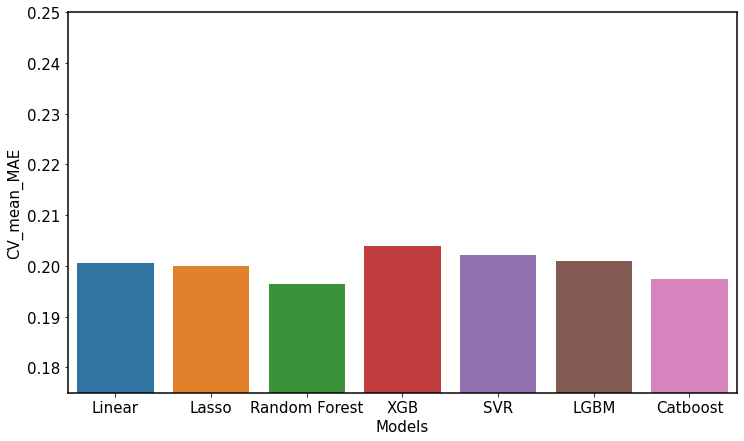

In [31]:
#Plot the scores for each model and compare to choose the best model

score_compare_dataframe=pd.DataFrame({'models':cv_model_array, 'scores':cv_scores_array})

plt.figure(figsize=(12,7))
plt.rcParams.update({'font.size': 15})
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5
sns.barplot(score_compare_dataframe.models, np.abs(score_compare_dataframe.scores))
plt.xlabel('Models')
plt.ylabel('CV_mean_MAE')
plt.ylim([.175,0.25])
plt.show()

In [36]:
optimized_params=catboost_model.get_all_params()
optimized_params['verbose']=False

In [43]:
# Since the Catboost model performs the best, we choose this as our final model

#we first get the optimal parameters from the grid search
optimized_params=catboost_model.get_params()
optimized_params['verbose']=False

#We then make a  model with these optimized parameters
optimized_catboost_model = CatBoostRegressor(**optimized_params)

optimized_catboost_model.fit(X_train, y_train);

y_pred=optimized_catboost_model.predict(X_test);

mae(np.expm1(y_test), np.expm1(y_pred))

0.45128541685117946

In [44]:
#pickle the model so that it can be used in a flask app
pickl={'model':optimized_catboost_model}
pickle.dump(pickl,open('model_file'+".p","wb"))

In [45]:
list(X.iloc[1,:])

[3.0,
 0.49677205178860884,
 0.8733832308628786,
 -1.8838470051076996,
 73.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]